<a href="https://colab.research.google.com/github/KarelZe/adv-ml/blob/main/AML_Bonus_MarkusBilz_2327197_VerenaHollinger_2055134.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imbalanced-learn

In [2]:
# TODO: Sort imports
# TODO: Format Code (PEP 8)

#import dependencies
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE


from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    matthews_corrcoef,
    plot_confusion_matrix,
    balanced_accuracy_score,
)
from yellowbrick.classifier.rocauc import roc_auc

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LassoCV, LogisticRegression, Lasso
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import tree

from scipy.stats import uniform, expon

from google.colab import drive

from statsmodels.api import OLS

import seaborn as sns
sns.set_theme(style="whitegrid", palette="viridis", font_scale=1.1, color_codes=True)
cmap = sns.cm.rocket

import matplotlib.pyplot as plt
%matplotlib inline

# increase the number of rows displayed to fully display all (transposed) features.
pd.options.display.max_rows = 1000


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

# Task 1: Explain dataset and business problems in two paragraphs. (10 points)

Peer-2-Peer Lending is a decentralized approach in which investors (most oftenly private investors) lend to debtors (typically private individuals). Peer-2-peer lending platforms such as Lending Club serve as an intermediary between investors and borrowers. Due to the decentralized structure, no banks are involved. The risk for a loan is that the borrower defaults partly or entirely. Expected interest and redemption payments may then not be made. The borrowers suffer a loss. Typically, investors invest in several loans to diversify their default risk. Ergo, one loan is financed by several investors. Of central interest is whether a default of a loan can be predicted and with which features. The platform could use this information to reject loans that are highly likely to default during the application process, thus avoiding defaults.

The dataset contains loan data on loans, that where distributed through the peer-2-peer lending platform Lending club. The data includes information on payment history, loan terms, borrower information and most importantly the loan status. In overview, data can be classified into hard and soft features. Some features are categorical e. g. term, while others are numerical e. g. debt-to-income-ratio or unstructured e. g. purpose.


**TODO: Hard vs. Soft features.**
**sollen wir sowas wie Anzahl features und Anzahl columns ergänzen?**



## Loading the data

Loan data is available from kaggle. The loan data is stored unaltered in our Google Drive.

Additional income data was downloaded from the [US Census Bureau](https://data.census.gov/cedsci/table?q=S1901%3A%20INCOME%20IN%20THE%20PAST%2012%20MONTHS%20%28IN%202018%20INFLATION-ADJUSTED%20DOLLARS%29&g=0400000US01,02,04,05,06,08,09,10,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56,72&tid=ACSST1Y2018.S1901&hidePreview=false). We use this information later in our analysis to compare the income of borrowers with the avg. income of the state they are located int. To be able to map US state names to their corresponding ISO-Codes we use es use the table found at [ISO.org](https://www.iso.org/obp/ui/#iso:code:3166:US) as a lookup table.

In [3]:
drive.mount("/content/drive")

data = pd.read_csv('/content/drive/My Drive/AdvancedML/accepted_2007_to_2018Q4.csv')
income_by_states = pd.read_csv('/content/drive/My Drive/AdvancedML/ACSST1Y2018_S1901_data_with_overlays_2021-06-12T020307.csv')

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Task 2: Do an explanatory analysis for this dataset. (10 points)

In [4]:
print(data.shape)

(2260701, 151)


The dataset consists of ~ 2.26 million loans and 151 features.

In [5]:
data.head().T

,0,1,2,3,4
id,68407277,68355089,68341763,66310712,68476807
member_id,NaN,NaN,NaN,NaN,NaN
loan_amnt,3600,24700,20000,35000,10400
funded_amnt,3600,24700,20000,35000,10400
funded_amnt_inv,3600,24700,20000,35000,10400
term,36 months,36 months,60 months,60 months,60 months
int_rate,13.99,11.99,10.78,14.85,22.45
installment,123.03,820.28,432.66,829.9,289.91
grade,C,C,B,C,F
sub_grade,C4,C1,B4,C5,F1


In [6]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,2.2607e+06,2.2607e+06,8.38861e+07,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
member_id,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,2.26067e+06,NaN,NaN,NaN,15046.9,9190.25,500,8000,12900,20000,40000
funded_amnt,2.26067e+06,NaN,NaN,NaN,15041.7,9188.41,500,8000,12875,20000,40000
funded_amnt_inv,2.26067e+06,NaN,NaN,NaN,15023.4,9192.33,0,8000,12800,20000,40000
term,2260668,2,36 months,1609754,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,2.26067e+06,NaN,NaN,NaN,13.0928,4.83214,5.31,9.49,12.62,15.99,30.99
installment,2.26067e+06,NaN,NaN,NaN,445.807,267.174,4.93,251.65,377.99,593.32,1719.83
grade,2260668,7,B,663557,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_grade,2260668,35,C1,145903,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Not all features are known at the time, when the loan is handed out. E. g. 'hardship_dpd' is not known. Therefore, a preselection is done to those features that can be known during the application process by using a [dictionary](https://drive.google.com/file/d/1UzyKMtrzL3aEEQpeYIz_qjBWyW-lAMr0/view). We restrict our further analysis to thhose features.

Moreover, the columns `url` or `desc`, as the info is no longer available on the lending club website.

Finally, we also drop the column `id`, as it is unique to the loan, but can not be used for a default prediction.

In [7]:
a_priori_known = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',  'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',  'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'revol_bal_joint']

# filter columns of data frame, that can be known in advance
data = data[a_priori_known]

Next, we look at missing data.

In [8]:
data.isna().sum()

loan_amnt                           33
funded_amnt                         33
funded_amnt_inv                     33
term                                33
int_rate                            33
installment                         33
grade                               33
sub_grade                           33
emp_title                       167002
emp_length                      146940
home_ownership                      33
annual_inc                          37
verification_status                 33
issue_d                             33
loan_status                         33
purpose                             33
title                            23358
zip_code                            34
addr_state                          33
dti                               1744
delinq_2yrs                         62
earliest_cr_line                    62
fico_range_low                      33
fico_range_high                     33
inq_last_6mths                      63
mths_since_last_delinq   

or visually for the first 50 rows:

In [9]:
def visualize_nan():
  fig,ax = plt.subplots(figsize=(20,10))
  sns.heatmap(data.head(50).isnull(), cbar=False);
  plt.xlabel("feature")
  plt.ylabel("row")
  plt.title("Viz. of missing values (colored in bright orange)")
  plt.show();

As it can be seen above, there is a high of missing data. While `dt_joint` and `acc_now_delinq` are missing more often than other features such as `title`, To further quantify this discovery, we use use a pareto plot in the next step. The missing values appear in a *completely random (MCAR)* fashion.

In [10]:
missing_val = data.isna().sum()
missing_val.sort_values(ascending=False, inplace=True)

missing_val = missing_val[missing_val > 1]
missing_val = missing_val.to_frame()

missing_val['pareto'] = 100 *missing_val[0].cumsum() / missing_val[0].sum()
missing_val.rename(columns={0:'nan'}, inplace=True)

print(missing_val.tail())

                      nan      pareto
initial_list_status    33   99.999555
last_fico_range_high   33   99.999667
last_fico_range_low    33   99.999778
policy_code            33   99.999889
loan_amnt              33  100.000000


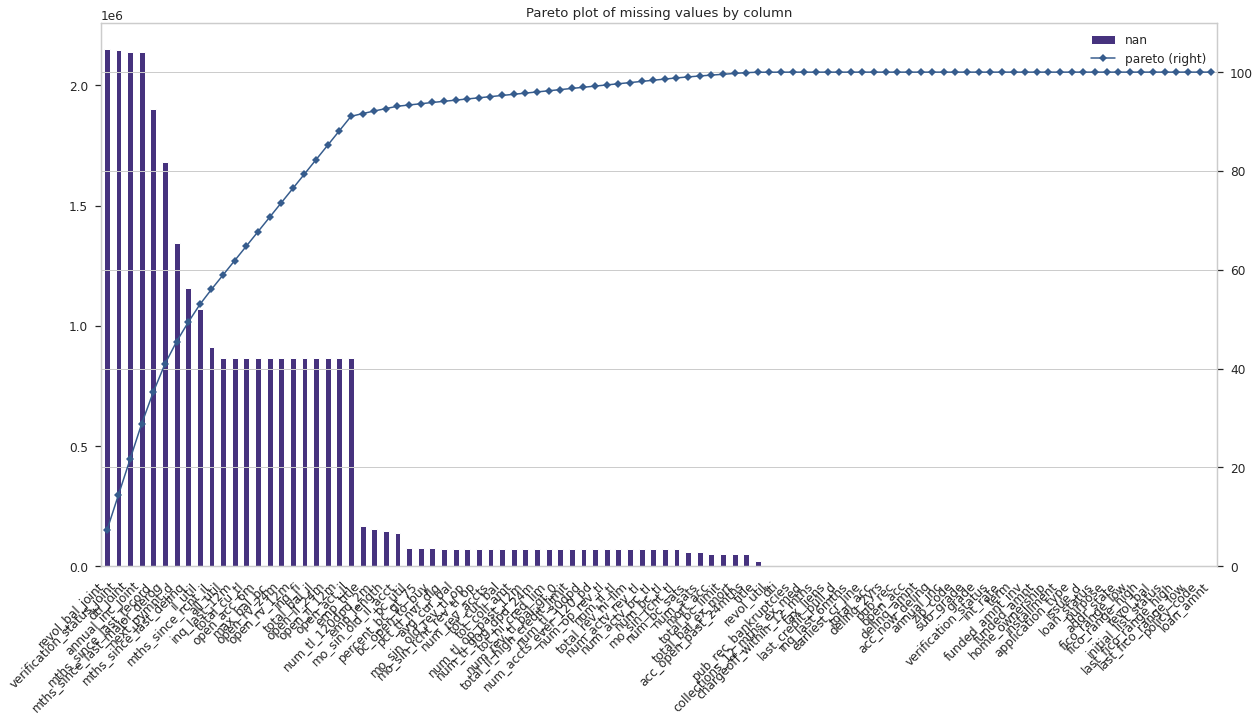

In [11]:
fig, axes = plt.subplots(figsize=(20,10))
ax1 = missing_val.plot(use_index=True, y='nan',  kind='bar', ax=axes)
ax2 = missing_val.plot(use_index=True, y='pareto', marker='D', color="C1", kind='line', ax=axes, secondary_y=True)
ax2.set_ylim([0,110])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
plt.xticks(rotation=45)
plt.title("Pareto plot of missing values by column")
plt.show()

To fix the problem of columns with a high degree of missing values, we exclude columns with more than 20 % of missing values. We are aware, that by removing features a bias is introduced. However, it's common practice to remove columns above this threshold, as shown in (...).

In [12]:
threshold = 0.80

percentage_missing_val = data.isna().sum()/len(data)

percentage_missing_val = percentage_missing_val[percentage_missing_val >= threshold]

print(percentage_missing_val)
threshold_abs = int(threshold * len(data))

data = data.dropna(axis=1, thresh=threshold_abs)

print(data.shape)

mths_since_last_record       0.841131
annual_inc_joint             0.946605
dti_joint                    0.946607
verification_status_joint    0.948808
revol_bal_joint              0.952218
dtype: float64
(2260701, 74)


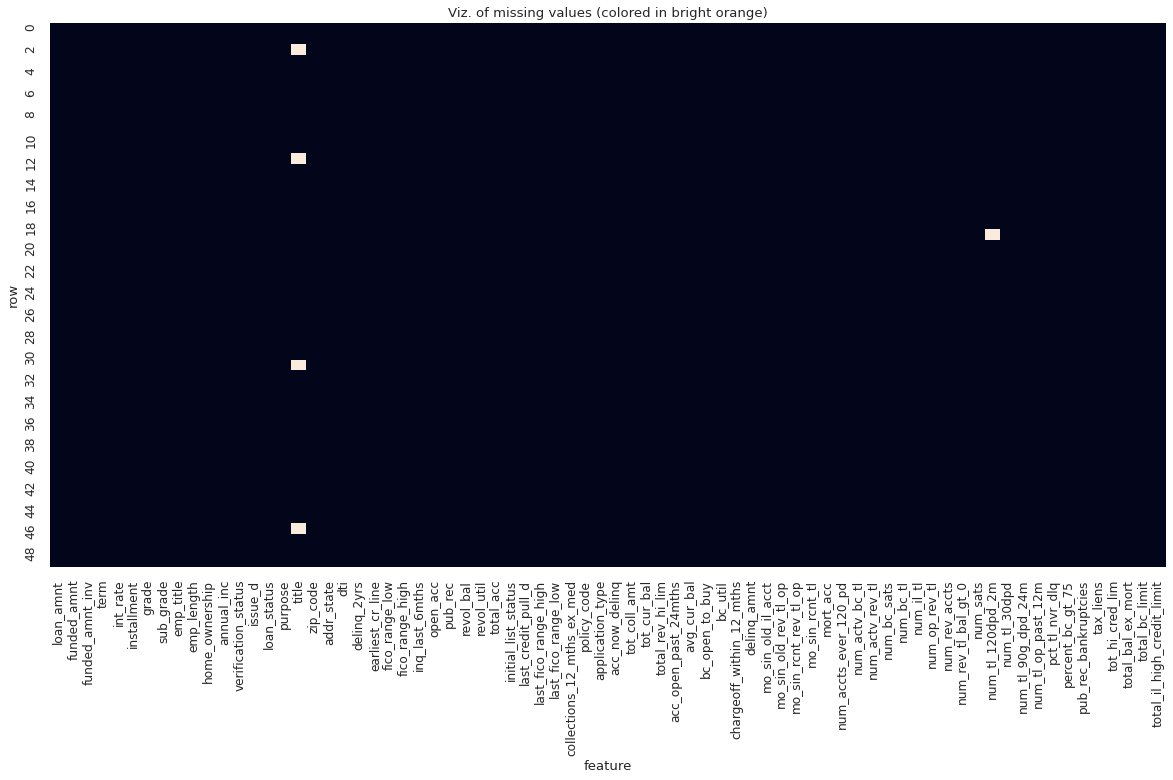

In [13]:
visualize_nan()

Looking at the Data Frame again...


Some rows are present, where the volume and many other features are null. We exclude these loans without volume from analysis.



In [14]:
data = data[data.loan_amnt.notna()]

This leads to the following result...

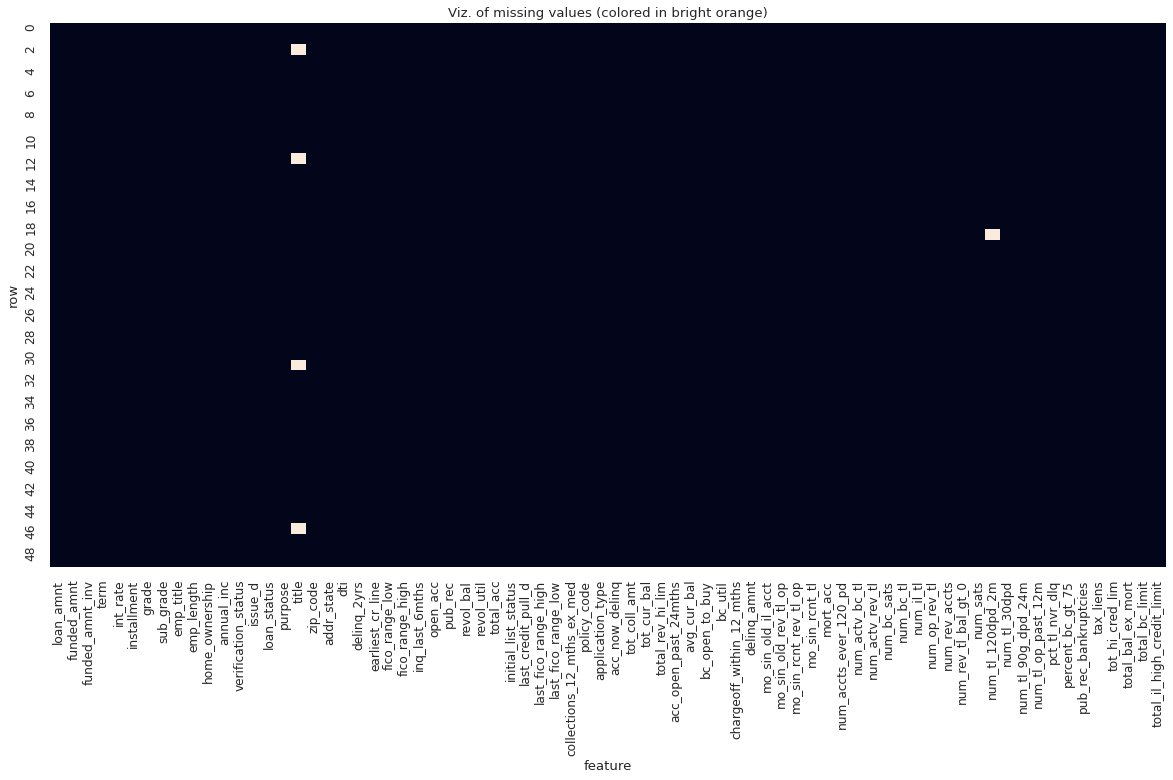

In [15]:
visualize_nan()

In [16]:
# convert to categorical
# TODO: -> apply manual order for some features V/M -> I checked the order of emp_length, grade and sub_grade. For grade and sub_grade it's correct. For emp_length I added a mapping instead of the cat codes to map it in the correct order. It's above the Label Encoding
categorical = ['addr_state', 'term', 'application_type', 'initial_list_status', 'loan_status', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose','emp_length', 'zip_code']
data[categorical] = data[categorical].apply(lambda x: x.astype('category'))

# convert to string
strs = ['emp_title', 'title']
data[strs] = data[strs].apply(lambda x: x.astype('string'))

# convert to datetime
dts = ['earliest_cr_line', 'issue_d', 'last_credit_pull_d']
data[dts] = data[dts].apply(lambda x: pd.to_datetime(x, format="%b-%Y",  errors='coerce'))

print(data.dtypes)

loan_amnt                            float64
funded_amnt                          float64
funded_amnt_inv                      float64
term                                category
int_rate                             float64
installment                          float64
grade                               category
sub_grade                           category
emp_title                             string
emp_length                          category
home_ownership                      category
annual_inc                           float64
verification_status                 category
issue_d                       datetime64[ns]
loan_status                         category
purpose                             category
title                                 string
zip_code                            category
addr_state                          category
dti                                  float64
delinq_2yrs                          float64
earliest_cr_line              datetime64[ns]
fico_range

##Number of unique classes per feature

In [17]:
data_classes = []
for row in data.columns.tolist():
    data_classes.append({'column': row, 'count': len(data[row].unique())})
amount = pd.DataFrame(data_classes).sort_values('count')
print(amount)

                        column   count
35                 policy_code       1
36            application_type       2
30         initial_list_status       2
3                         term       2
12         verification_status       3
63                num_tl_30dpd       6
10              home_ownership       6
6                        grade       7
62            num_tl_120dpd_2m       8
14                 loan_status       9
37              acc_now_delinq      10
9                   emp_length      12
45    chargeoff_within_12_mths      12
68        pub_rec_bankruptcies      13
15                     purpose      14
34  collections_12_mths_ex_med      17
24              inq_last_6mths      29
65          num_tl_op_past_12m      34
64          num_tl_90g_dpd_24m      35
7                    sub_grade      35
20                 delinq_2yrs      38
69                   tax_liens      43
53              num_actv_bc_tl      43
26                     pub_rec      44
52       num_accts_ever_1

The features `purpose` and `title` contain similar content. Since `purpose` only contains 14 classes and `title` contains more than 60,000 classes we keep `purpose` and drop `title`.

More over we drop `emp_title`, as it contains either free-text or a high number of unique values, which is true for the later. We expect little loss in information by deleting these variables.

As `policy_code` is constant, it can be also dropped.

In [18]:
data = data.drop(columns=['emp_title', 'title', 'policy_code'])

Next, we analyze categorical features by looking at their $k$ most frequent values.

In [19]:
k = 10
data['term'].value_counts().head(k)

 36 months    1609754
 60 months     650914
Name: term, dtype: int64

In [20]:
data['addr_state'].value_counts().head(k)

CA    314533
NY    186389
TX    186335
FL    161991
IL     91173
NJ     83132
PA     76939
OH     75132
GA     74196
VA     62954
Name: addr_state, dtype: int64

In [21]:
data['application_type'].value_counts().head(k)

Individual    2139958
Joint App      120710
Name: application_type, dtype: int64

In [22]:
data['initial_list_status'].value_counts().head(k)

w    1535467
f     725201
Name: initial_list_status, dtype: int64

In [23]:
data['loan_status'].value_counts().head(k)

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [24]:
data['grade'].value_counts().head(k)

B    663557
C    650053
A    433027
D    324424
E    135639
F     41800
G     12168
Name: grade, dtype: int64

In [25]:
data['sub_grade'].value_counts().head(k)

C1    145903
B5    140288
B4    139793
B3    131514
C2    131116
C3    129193
C4    127115
B2    126621
B1    125341
C5    116726
Name: sub_grade, dtype: int64

In [26]:
data['home_ownership'].value_counts().head(k)

MORTGAGE    1111450
RENT         894929
OWN          253057
ANY             996
OTHER           182
NONE             54
Name: home_ownership, dtype: int64

In [27]:
data['verification_status'].value_counts().head(k)

Source Verified    886231
Not Verified       744806
Verified           629631
Name: verification_status, dtype: int64

In [28]:
data['purpose'].value_counts().head(k)

debt_consolidation    1277877
credit_card            516971
home_improvement       150457
other                  139440
major_purchase          50445
medical                 27488
small_business          24689
car                     24013
vacation                15525
moving                  15403
Name: purpose, dtype: int64

In [29]:
data['emp_length'].value_counts().head(k)

10+ years    748005
2 years      203677
< 1 year     189988
3 years      180753
1 year       148403
5 years      139698
4 years      136605
6 years      102628
7 years       92695
8 years       91914
Name: emp_length, dtype: int64

##Analyze loan status
In a first step the different loan status categories and their quantities are identified to categorize them in "default" and "non-default"

In [30]:
data['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

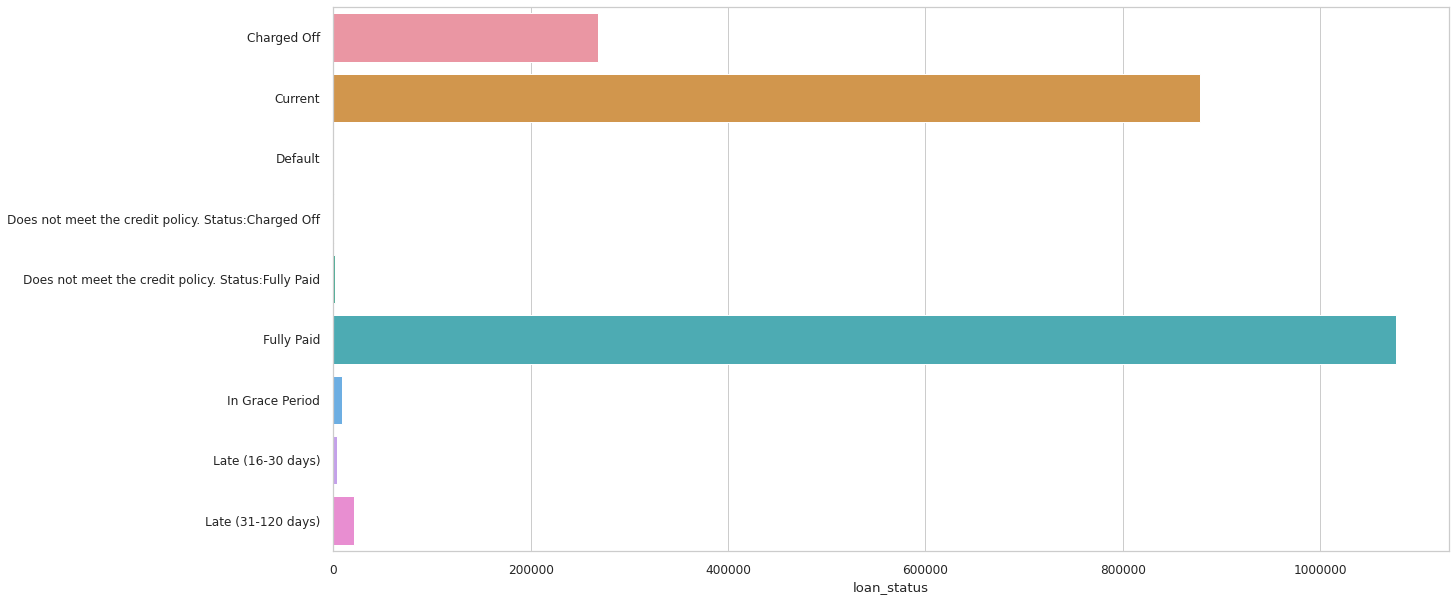

In [31]:
loan_status_absolute = data['loan_status'].value_counts()
loan_status_absolute = loan_status_absolute.to_frame()

fig, ax = plt.subplots(figsize=(20,10))
plt.ticklabel_format(style='plain')
sns.barplot(x='loan_status', y=loan_status_absolute.index,  data=loan_status_absolute, ax=ax);

Next, we group `loan_status` to be either default or non-default to allow for binary classsification. We save the result as `TARGET`.

We apply the same grouping as *Vinod Kumar, Natajan et. al* in *Credit Risk Analysis in Peer-to-Peer Lending System*.

In [32]:
default_categories = ['Default', 'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Does not meet the credit policy. Status:Charged Off']
data['TARGET'] = data['loan_status'].isin(default_categories)

data['TARGET'].value_counts()

False    1965492
True      295176
Name: TARGET, dtype: int64

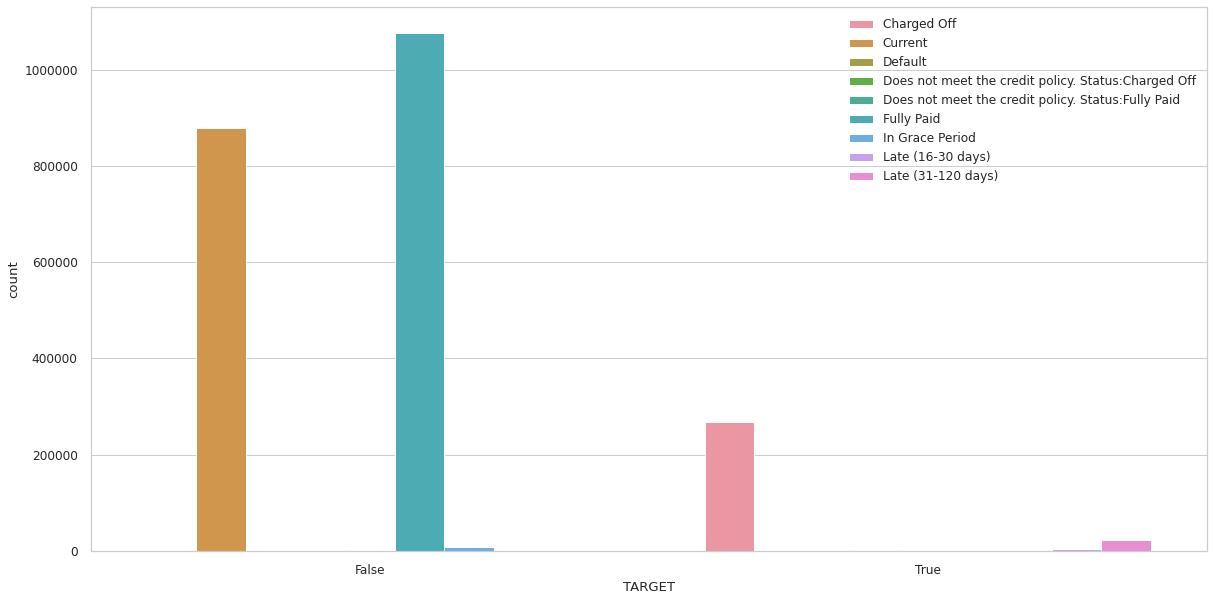

In [33]:
fig, ax = plt.subplots(figsize=(20,10))
plt.ticklabel_format(style='plain')
g = sns.countplot(x='TARGET', hue='loan_status', data=data);
g.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1);
plt.show();

## default status by debt-to-income-ratio
- For calculation of debt-to-income-ratio see [here.](https://www.lendingclub.com/loans/resource-center/calculating-debt-to-income)

**expectation**
- One would expect more defaults with a higher debt-to-income ratio, but no clear trend can be derived from data.

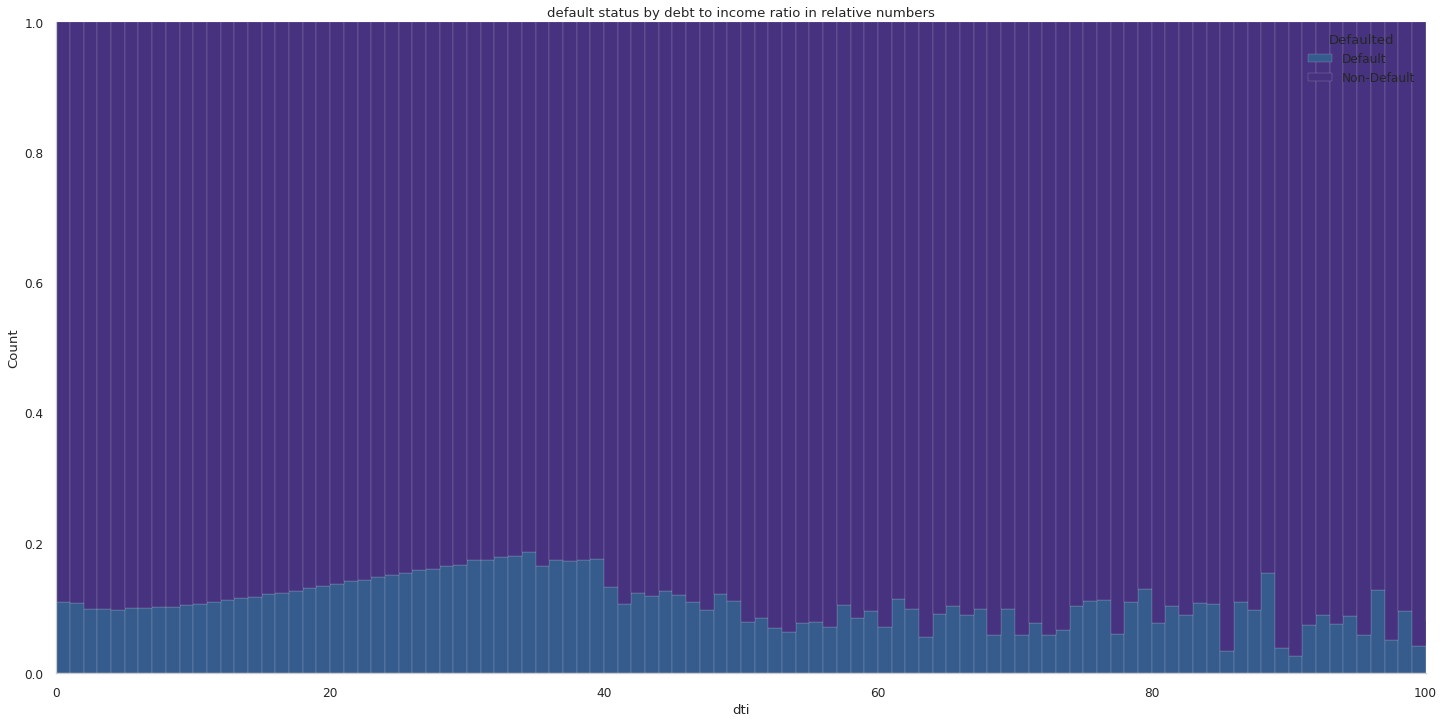

In [34]:
g = sns.displot(data, x='dti', hue='TARGET', multiple='fill', legend=False, height=10, aspect=20/10, alpha=1, bins=1000)
plt.title("default status by debt to income ratio in relative numbers")
plt.xlim(0, 100)
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'])
plt.show(g);

## default status by term structure and amount

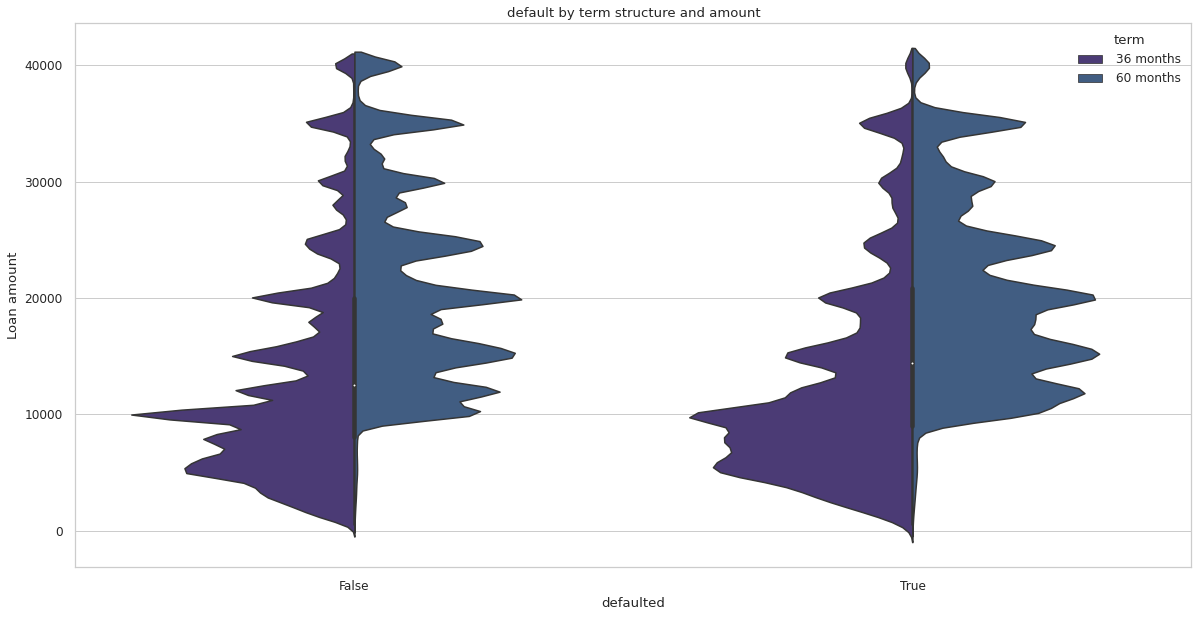

In [35]:
fig = plt.figure(figsize=(20,10))
sns.violinplot(x="TARGET",y="loan_amnt",data=data, hue="term", split=True)
plt.title("default by term structure and amount")
plt.xlabel("defaulted")
plt.ylabel("Loan amount");

## default status by grade

**expectation**
- Loans with a lower rating inherit a higher risk of default.

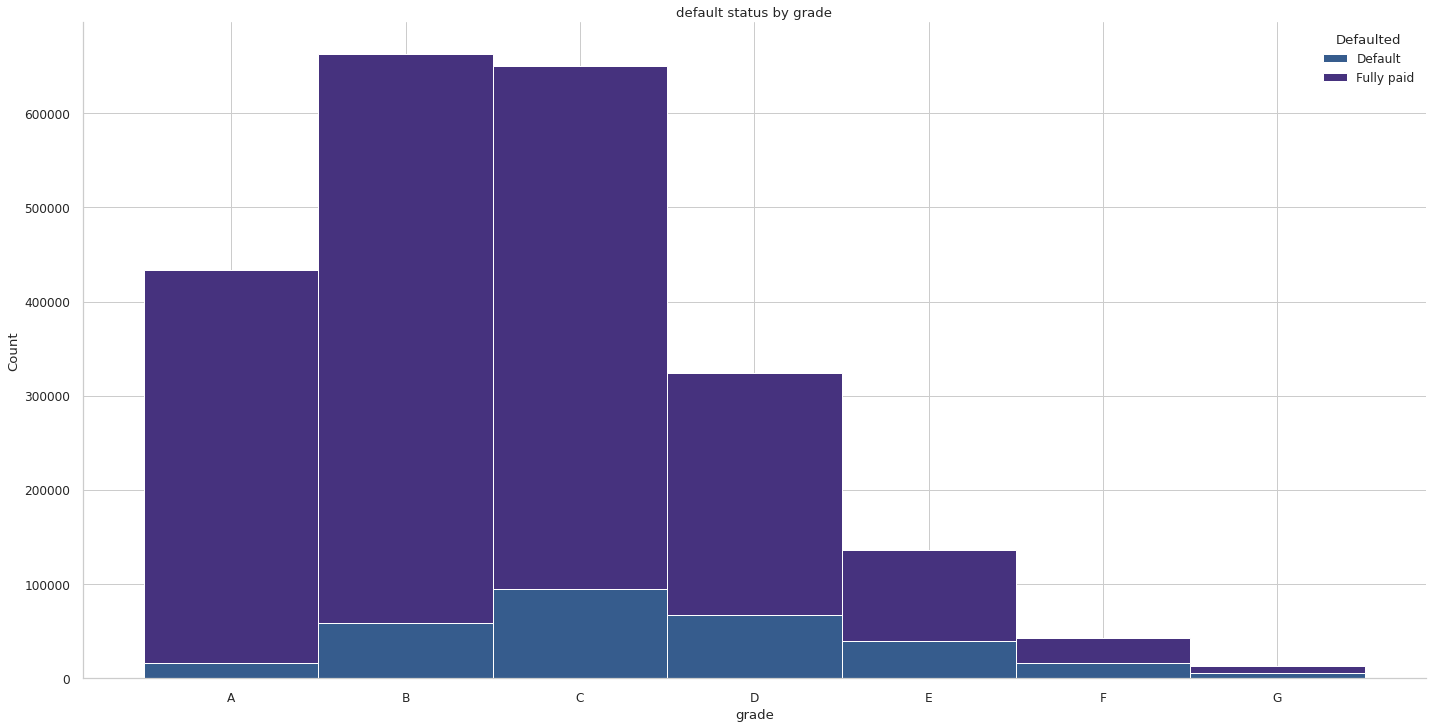

In [36]:
g = sns.displot(data, x='grade', hue='TARGET', multiple='stack', legend=False, height=10, aspect=20/10, alpha=1);
plt.title("default status by grade")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Fully paid'])
plt.show(g);

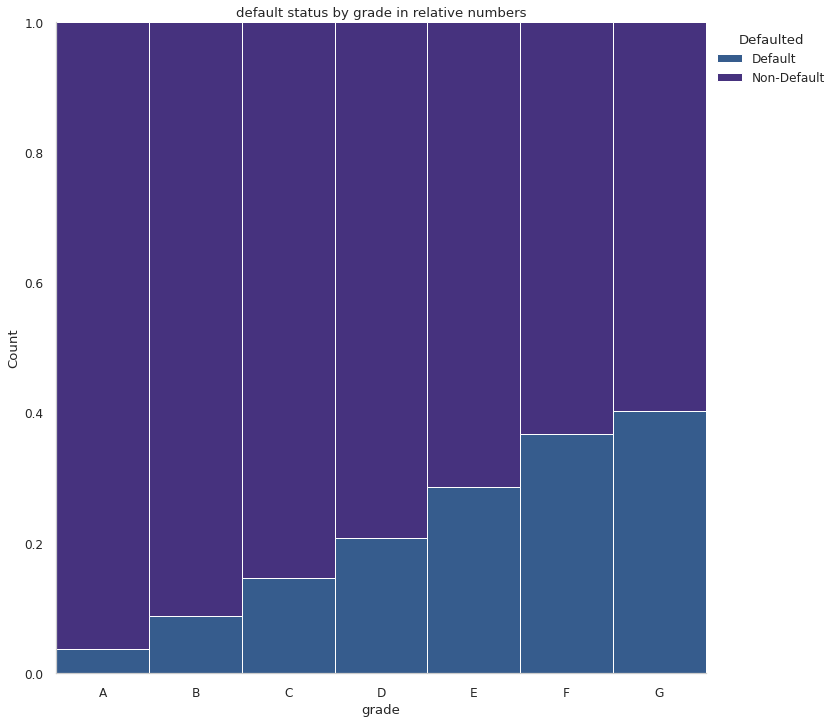

In [37]:
# TODO: As observed by researchers xy...

g = sns.displot(data, x='grade', hue='TARGET', multiple='fill', legend=False, height=10, aspect=1, alpha=1)
plt.title("default status by grade in relative numbers")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'], bbox_to_anchor=(1.2, 1))
plt.show(g);

## default status by grade and interest rate

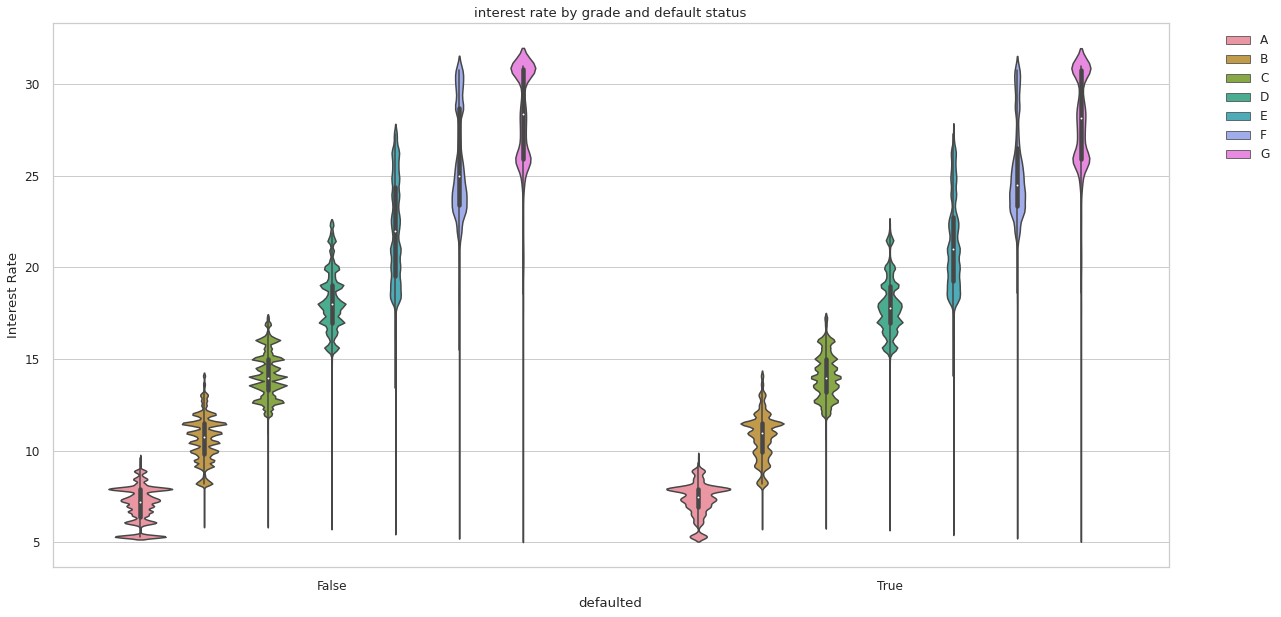

In [38]:
fig = plt.figure(figsize=(20,10))
sns.violinplot(x="TARGET",y="int_rate",data=data, hue="grade")
plt.legend(bbox_to_anchor=(1.1, 1))
plt.title("interest rate by grade and default status")
plt.xlabel("defaulted")
plt.ylabel("Interest Rate");

# Default status by application type

**expectation**
- Joint applications inherit lower risk of default.

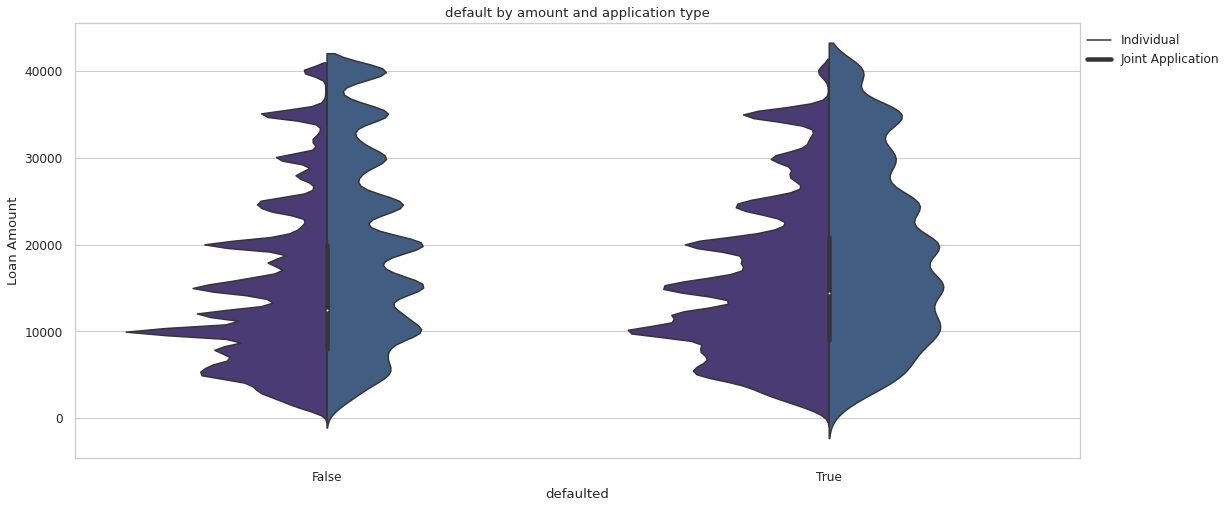

In [39]:
fig = plt.figure(figsize=(18,8))
sns.violinplot(x="TARGET",y="loan_amnt",data=data, hue="application_type", split=True)
plt.title("default by amount and application type")
plt.xlabel("defaulted")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1, labels=['Individual', 'Joint Application']);
plt.ylabel("Loan Amount");

## Default status by working experience

**expectation**
- The longer the working experience, the smaller the probability of default.

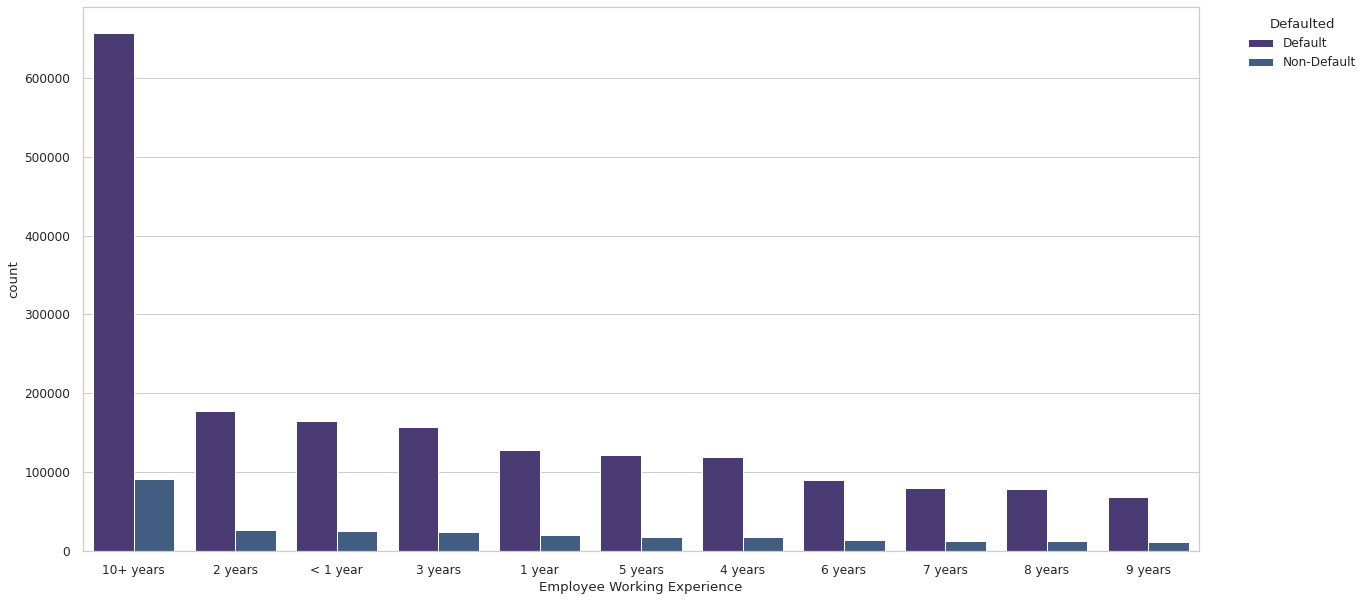

In [40]:
fig = plt.figure(figsize=(20,10))

sns.countplot(x='emp_length', hue='TARGET', data=data, order = data['emp_length'].value_counts().index)
plt.xlabel('Employee Working Experience')
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'], bbox_to_anchor=(1.15, 1))
plt.show()

## Default status by state

**expectation**
- None.

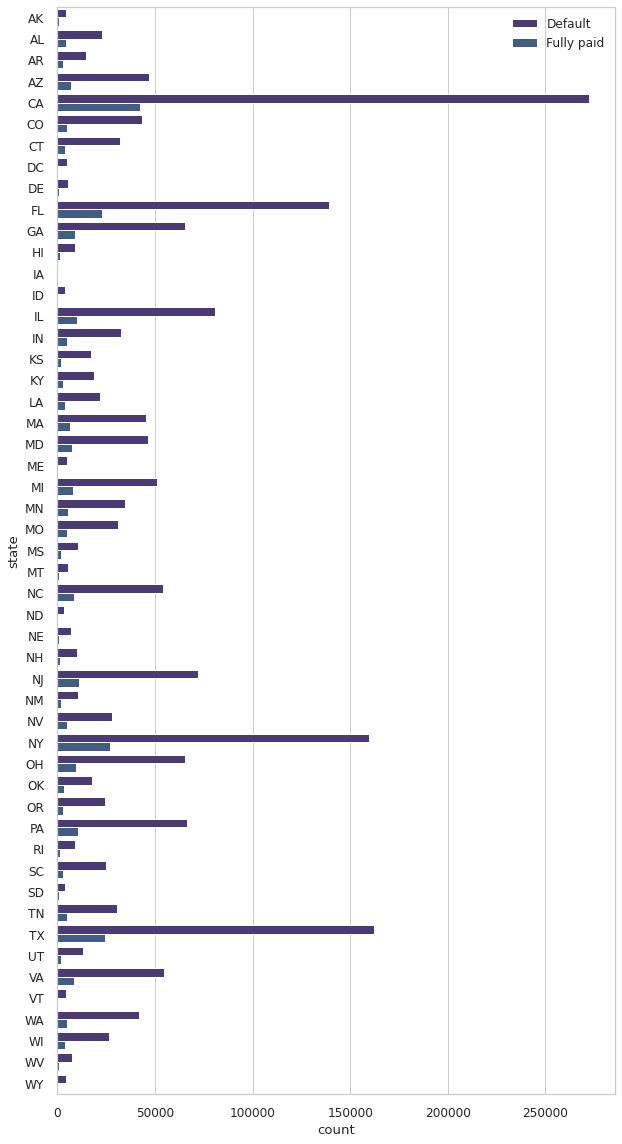

In [41]:
fig, ax = plt.subplots(figsize=(10,20))
plt.ticklabel_format(style='plain')
g = sns.countplot(y='addr_state', hue='TARGET', data=data, ax=ax);
g.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1, labels=['Default', 'Fully paid']);
plt.ylabel("state")
plt.xlabel("count")
plt.show();

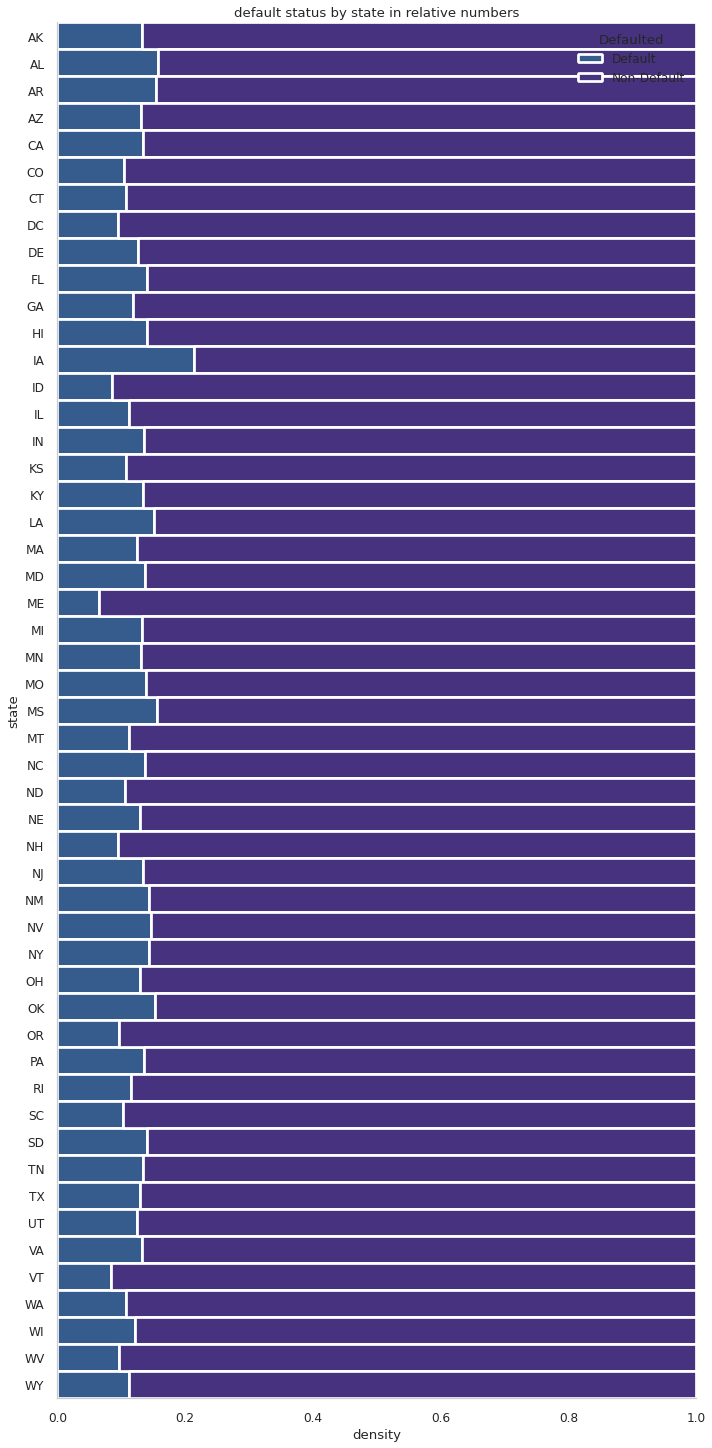

In [42]:
# TODO: Discussion IA vs. ID (few observations)

g = sns.displot(data, y='addr_state', hue='TARGET', multiple='fill', legend=False, height=20, aspect=10/20, alpha=1)
plt.title("default status by state in relative numbers")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'])
plt.ylabel("state")
plt.xlabel("density")
plt.show(g);

## default status by purpose

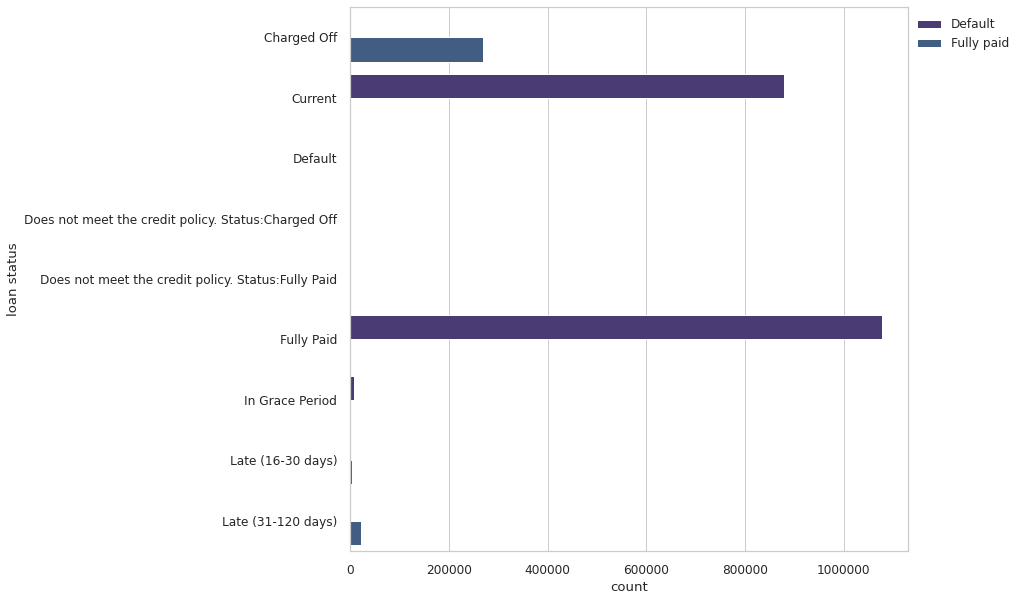

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
plt.ticklabel_format(style='plain')
g = sns.countplot(y='loan_status', hue='TARGET', data=data, ax=ax);
g.legend(loc='upper right', bbox_to_anchor=(1.2, 1), ncol=1, labels=['Default', 'Fully paid']);
plt.ylabel("loan status")
plt.show();

## Interest rate by grade

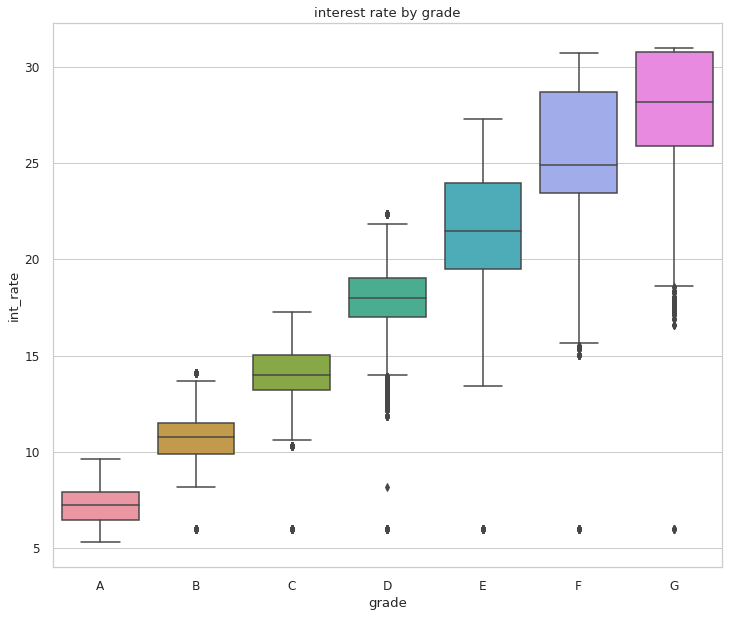

In [44]:
plt.figure(figsize=(12,10))
g = sns.boxplot(data=data, x='grade', y='int_rate')
plt.title("interest rate by grade")
plt.show(g);

## default status by interest rate

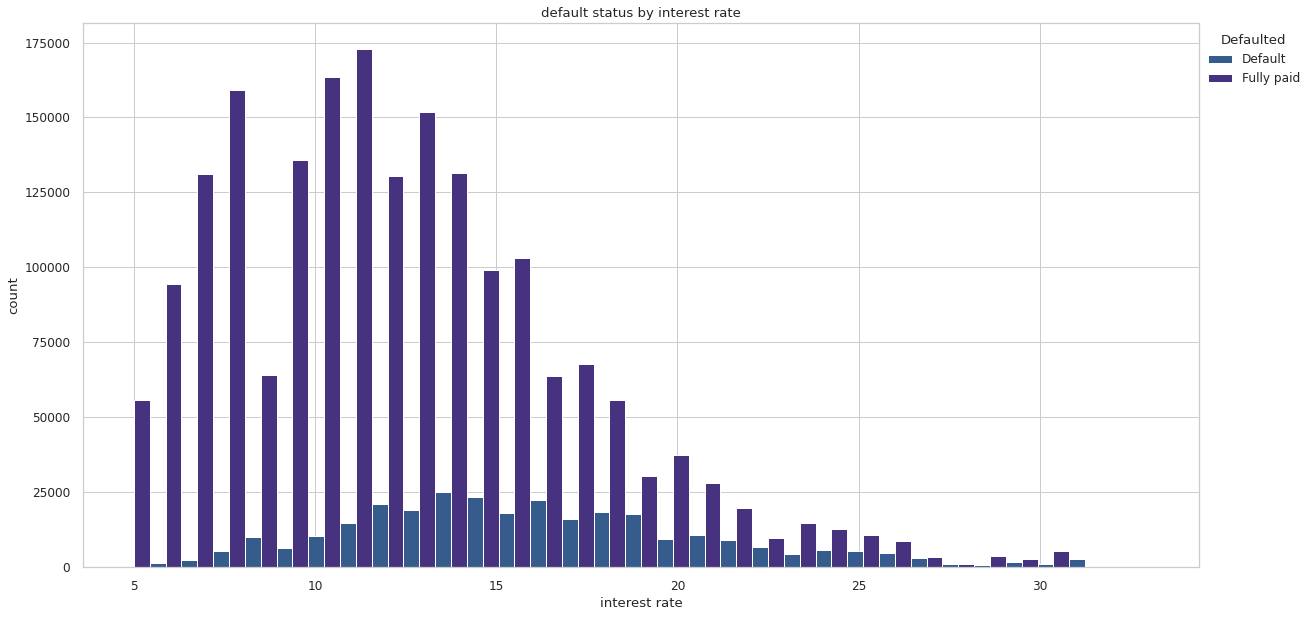

In [45]:
plt.figure(figsize=(20,10))
bins = np.linspace(5, 33, 33)
g = sns.histplot(data, x='int_rate', hue='TARGET', multiple='dodge', legend=False, alpha=1, bins=bins);
plt.title("default status by interest rate")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Fully paid'], bbox_to_anchor=(1.1, 1))
plt.xlabel("interest rate")
plt.ylabel("count")
plt.show(g);

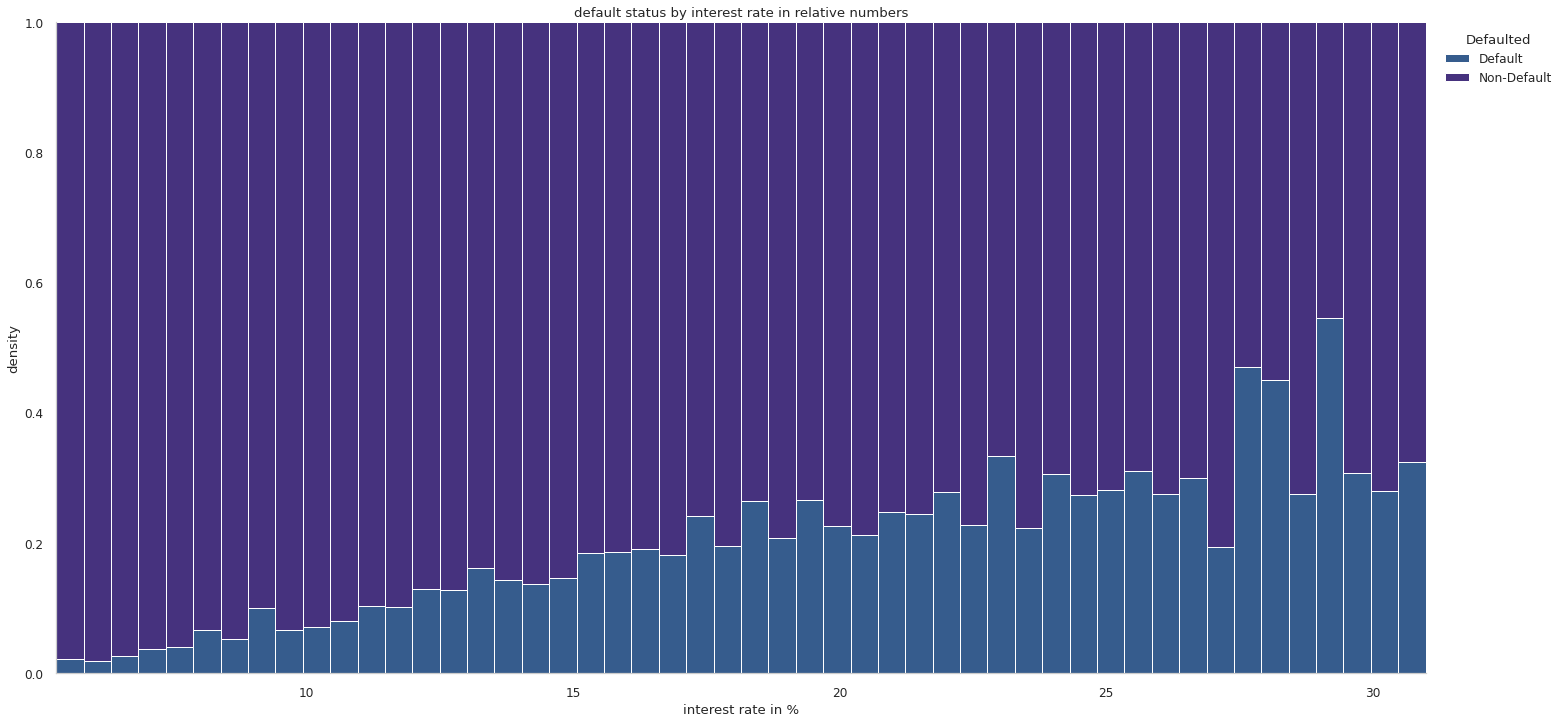

In [46]:
# TODO: Mind bin size. There are interest rates with only few loans. This might lead to distortions.

g = sns.displot(data, x='int_rate', hue='TARGET', multiple='fill', legend=False, height=10, bins = 50, aspect=20/10, alpha=1)
plt.title("default status by interest rate in relative numbers")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'], bbox_to_anchor=(1.1, 1))
plt.xlabel("interest rate in %")
plt.ylabel("density")
plt.show();

## Analyze income


In [47]:
income_by_states = income_by_states[['NAME', 'S1901_C01_013E']]
income_by_states.rename(columns={'NAME':'state','S1901_C01_013E': 'income'}, inplace=True)

income_by_states.head(60)

,state,income
0,Geographic Area Name,Estimate!!Households!!Mean income (dollars)
1,Alabama,69091
2,Alaska,96080
3,Arizona,80477
4,Arkansas,66766
5,California,107384
6,Colorado,96218
7,Connecticut,111303
8,Delaware,84896
9,Florida,79968


In [48]:
state_map = pd.read_csv("/content/drive/My Drive/AdvancedML/states_mapping.csv", sep=';')
state_map.head(50)

,iso_code,subdivision_name
0,AL,Alabama
1,AK,Alaska
2,AS,American Samoa
3,AZ,Arizona
4,AR,Arkansas
5,CA,California
6,CO,Colorado
7,CT,Connecticut
8,DE,Delaware
9,DC,District of Columbia


In [49]:
# remove comments from df
income_by_states.drop(income_by_states.index[[0]], inplace=True)

# add iso codes and make subselection
income_by_states = income_by_states.merge(state_map,how='left',left_on='state', right_on='subdivision_name')
income_by_states = income_by_states[['iso_code', 'income']]

income_by_states.head(60)

,iso_code,income
0,AL,69091
1,AK,96080
2,AZ,80477
3,AR,66766
4,CA,107384
5,CO,96218
6,CT,111303
7,DE,84896
8,FL,79968
9,GA,82489


In [50]:
lut_income = dict(income_by_states.values)
data["addr_state_avg_income"] = data["addr_state"].replace(lut_income)
data["addr_state_avg_income"] = data["addr_state_avg_income"].apply(lambda x: pd.to_numeric(x,errors="coerce")) 
data["state_income_ratio"] = data["annual_inc"] / data["addr_state_avg_income"]
data.head().T

,0,1,2,3,4
loan_amnt,3600,24700,20000,35000,10400
funded_amnt,3600,24700,20000,35000,10400
funded_amnt_inv,3600,24700,20000,35000,10400
term,36 months,36 months,60 months,60 months,60 months
int_rate,13.99,11.99,10.78,14.85,22.45
installment,123.03,820.28,432.66,829.9,289.91
grade,C,C,B,C,F
sub_grade,C4,C1,B4,C5,F1
emp_length,10+ years,10+ years,10+ years,10+ years,3 years
home_ownership,MORTGAGE,MORTGAGE,MORTGAGE,MORTGAGE,MORTGAGE


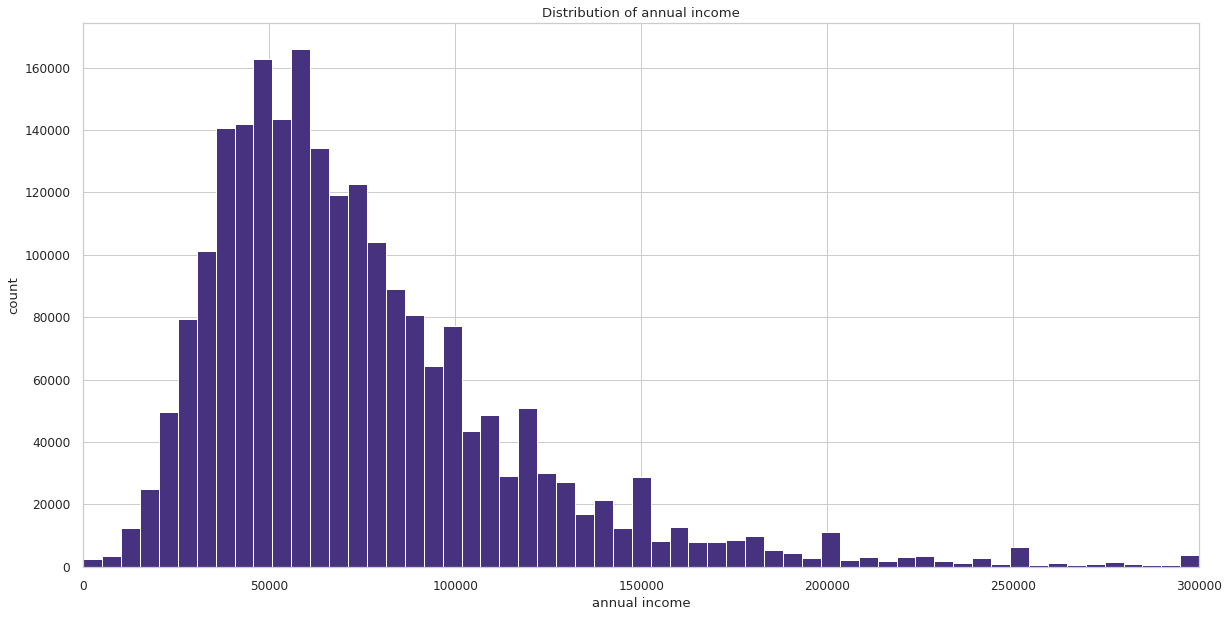

In [51]:
fig = plt.figure(figsize=(20,10))
bins = np.linspace(0, 300000, 60)
sns.histplot(data= data, x='annual_inc', bins=bins, kde=False, alpha=1)
plt.title("Distribution of annual income")
plt.xlim(0, 300000)
plt.xlabel("annual income")
plt.ylabel("count")
plt.show()

## Annual Income and Loan Amount of defaulted loans

<Figure size 1440x1440 with 0 Axes>

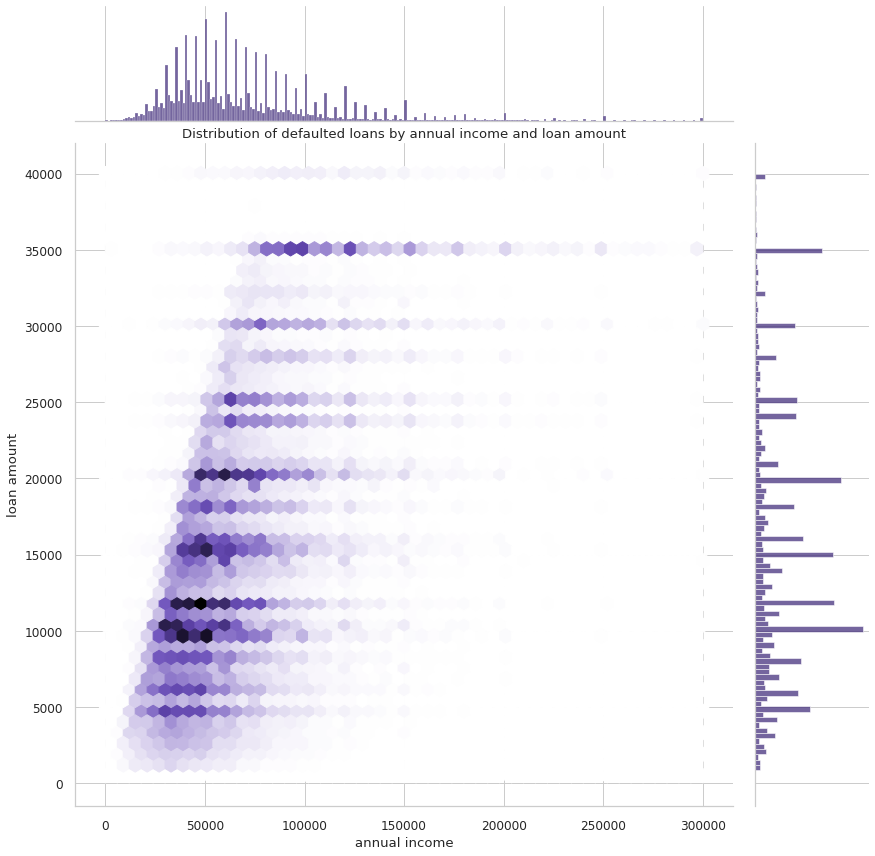

In [52]:
fig = plt.figure(figsize=(20,20))
sel_annual_inc_defaulted= data[(data.annual_inc <= 300000) & (data.TARGET==1)]
sns.jointplot(data=sel_annual_inc_defaulted, x="annual_inc", y="loan_amnt", kind="hex", height=12)
plt.xlabel("annual income")
plt.ylabel("loan amount")
plt.title("Distribution of defaulted loans by annual income and loan amount")
plt.show()

##Analyze effect of joint/ individual application

In [53]:
data['application_type'].value_counts()

Individual    2139958
Joint App      120710
Name: application_type, dtype: int64

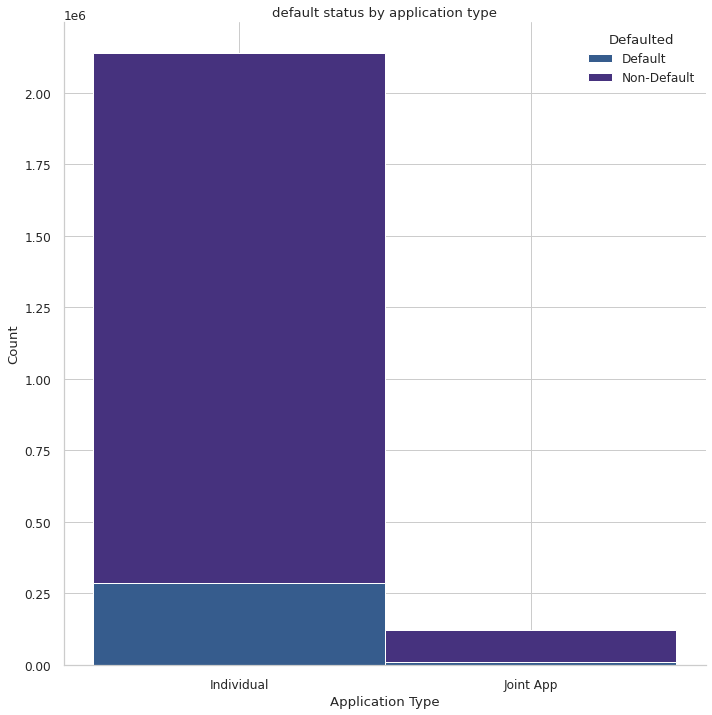

In [54]:
g = sns.displot(data, x='application_type', hue='TARGET', multiple='stack', legend=False, alpha=1, height = 10, aspect=10/10)
plt.xlabel("Application Type")
plt.title("default status by application type")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'])

plt.show(g);

In [55]:
# enable again for final file
# data_jointapp = data.loc[data['application_type'] == 'Joint App']
# data_indidualapp = data.loc[data['application_type'] == 'Individual']

In [56]:
# FIXME: die Methode ist irgendwo rauskopiert, wenn wir sie drin lassen wollen muss ich sie noch ein bisschen was abändern V --> abgeändert
def null_values(data):
        mis_val = data.isnull().sum()
        mis_val_percent = 100 * data.isnull().sum() / len(data)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Number of Missing Values', 1 : 'Percentage'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        'Percentage', ascending=False).round(2)
        print ("In the dataset are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [57]:
# FIXME: Enable again for final file
#miss_values = null_values(data_jointapp)
#miss_values.head(20)

In [58]:
# miss_values = null_values(data_indidualapp)
# miss_values.head(20)

In [59]:
# miss_values = null_values(data)
# miss_values.head()


## Data Preprocessing

As the amount of missing values, that remain in the dataset, is relatively small, we fill missing values with the modus of each feature.

In [60]:
data.fillna(data.mode().iloc[0], inplace = True)

This leads to the following result...

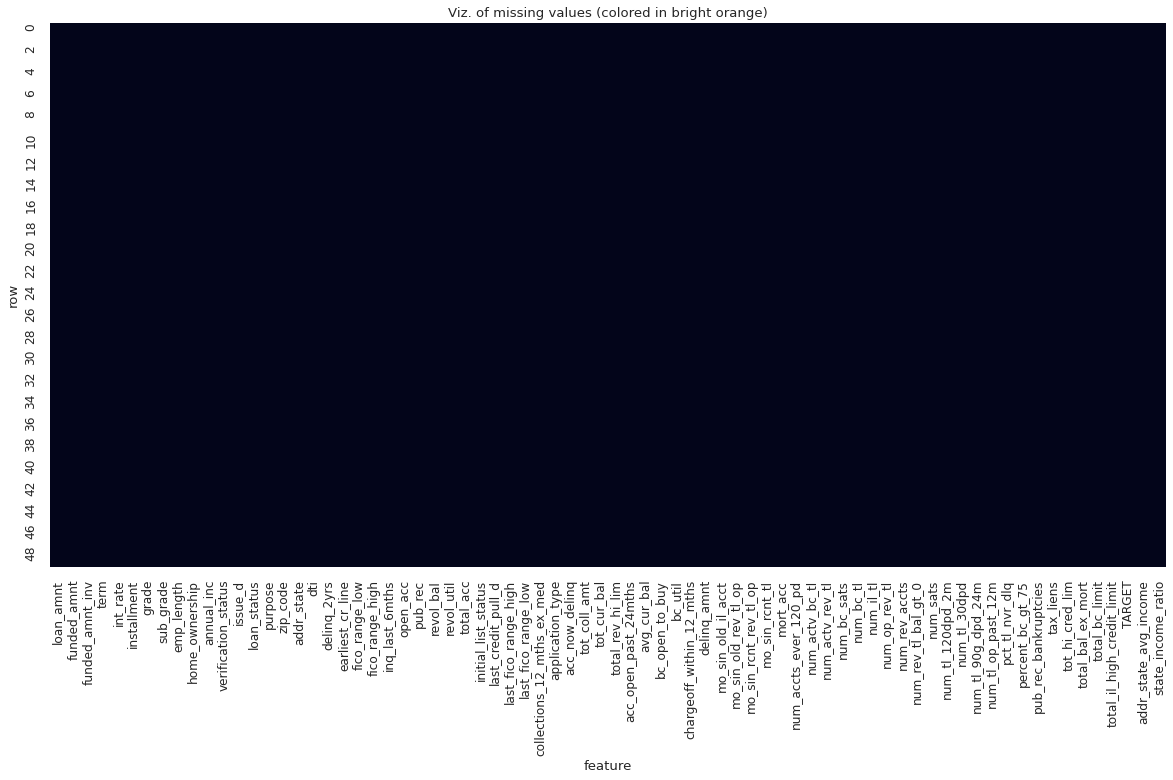

In [61]:
visualize_nan()

As seen above the dataset contains 2,260,701 entries. This sheer amount of data is hard is hard to process with the tools and processing ressources, that we have to our disposal. Therefore, we apply stratified sampling first on the dataset to create a subset with a similiar distribution to the original data. The resulting dataset will be 20 % of the original data set.

In [62]:
# Remove target and loan status from features
features = data.drop(columns=['loan_status', 'TARGET'], axis=1)
# create a 20 % random subselection
# TODO: Decreased to 5 % for faster training. Change to 20 % later.
X_stratified, _, y_stratified, _ = train_test_split(features, data.TARGET, test_size=0.95, random_state=42, stratify=data.TARGET)

Next, we split the stratified data into two parts. Namely, training data and test data. The training data will be used to train the models and for in-sample testing. Whereas the test data is used for out-of-sample testing. This time we use a 70 % / 30 % split.


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_stratified, y_stratified, stratify=y_stratified, test_size=0.3, random_state=42)

In [64]:
print(X_train.dtypes)

loan_amnt                            float64
funded_amnt                          float64
funded_amnt_inv                      float64
term                                category
int_rate                             float64
installment                          float64
grade                               category
sub_grade                           category
emp_length                          category
home_ownership                      category
annual_inc                           float64
verification_status                 category
issue_d                       datetime64[ns]
purpose                             category
zip_code                            category
addr_state                          category
dti                                  float64
delinq_2yrs                          float64
earliest_cr_line              datetime64[ns]
fico_range_low                       float64
fico_range_high                      float64
inq_last_6mths                       float64
open_acc  

As seen during data exploration the data set is highly imbalanced. Non-default loans are much more frequent than defaulted loans. We use a variant of 'SMOTE' ([see](https://arxiv.org/pdf/1106.1813.pdf) and [see](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html)) to upsample the defaulted class, which is relatively rare in the raw data. This sampling is only applied on the training data.

In [65]:
# TODO: replace with ordinary smote and place at end --> added SMOTE at the end

# FIXME: research proper ways of handling strings and timestamps 
# or reposition in jupyter notebook and use standard implementation.
# Currently disabled to improve performance while development

# categorial = X_train.select_dtypes(include=['category','string', 'datetime64[ns]'])
# categorial_mask = np.isin(X_train.columns, categorial.columns)

# smote = SMOTENC(random_state=42, k_neighbors=2**7, categorical_features=categorial_mask)
# X_train, y_train = smote.fit_resample(X_train, y_train)

Having `datetime64[ns]` dtypes e. g. for `issue_d` is desireable for visualization. However, using these datetypes in our models causes difficulties, as the datetime object have to be converted to some numeric value. We only keep the 'year' component.

In [66]:
# See discussion here  https://stats.stackexchange.com/a/311498

# apply to Test and Training set
datetime_columns = data.select_dtypes(include=['datetime64[ns]']).columns

datetime_columns_month = [s + "_mth" for s in datetime_columns]

X_train[datetime_columns_month] = X_train[datetime_columns].apply(lambda x: x.dt.month)
X_test[datetime_columns_month] = X_test[datetime_columns].apply(lambda x: x.dt.month)

X_train[datetime_columns] = X_train[datetime_columns].apply(lambda x: x.dt.year)
X_test[datetime_columns] = X_test[datetime_columns].apply(lambda x: x.dt.year)


print(X_train.dtypes)

loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
term                          category
int_rate                       float64
installment                    float64
grade                         category
sub_grade                     category
emp_length                    category
home_ownership                category
annual_inc                     float64
verification_status           category
issue_d                          int64
purpose                       category
zip_code                      category
addr_state                    category
dti                            float64
delinq_2yrs                    float64
earliest_cr_line                 int64
fico_range_low                 float64
fico_range_high                float64
inq_last_6mths                 float64
open_acc                       float64
pub_rec                        float64
revol_bal                      float64
revol_util               

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


While variables of type 'Categorical' are great for visualization, they also require further processing to be used by machine learning models. We apply some Label-encoding. The problem with label encoding is, that an unfortunate ordering can lead to poor results when applying our models.

To adress this issue, use a 2 step approach:
- We use label encoding provided by pandas, if the ordering is appropriate.
- Otherwise, we apply some manual ordering.

In order to do so, we first check the order for all categorical variables, to find out which variables require manual ordering.

In [67]:
# TODO: Mapping itself introduces bias
cat_columns = X_train.select_dtypes(include=['category']).columns

for cat in cat_columns:
  map = dict(enumerate(X_train[cat].cat.categories))
  print(f"{cat}: {map}")

term: {0: ' 36 months', 1: ' 60 months'}
grade: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G'}
sub_grade: {0: 'A1', 1: 'A2', 2: 'A3', 3: 'A4', 4: 'A5', 5: 'B1', 6: 'B2', 7: 'B3', 8: 'B4', 9: 'B5', 10: 'C1', 11: 'C2', 12: 'C3', 13: 'C4', 14: 'C5', 15: 'D1', 16: 'D2', 17: 'D3', 18: 'D4', 19: 'D5', 20: 'E1', 21: 'E2', 22: 'E3', 23: 'E4', 24: 'E5', 25: 'F1', 26: 'F2', 27: 'F3', 28: 'F4', 29: 'F5', 30: 'G1', 31: 'G2', 32: 'G3', 33: 'G4', 34: 'G5'}
emp_length: {0: '1 year', 1: '10+ years', 2: '2 years', 3: '3 years', 4: '4 years', 5: '5 years', 6: '6 years', 7: '7 years', 8: '8 years', 9: '9 years', 10: '< 1 year'}
home_ownership: {0: 'ANY', 1: 'MORTGAGE', 2: 'NONE', 3: 'OTHER', 4: 'OWN', 5: 'RENT'}
verification_status: {0: 'Not Verified', 1: 'Source Verified', 2: 'Verified'}
purpose: {0: 'car', 1: 'credit_card', 2: 'debt_consolidation', 3: 'educational', 4: 'home_improvement', 5: 'house', 6: 'major_purchase', 7: 'medical', 8: 'moving', 9: 'other', 10: 'renewable_energy', 11: 'smal

As it can be seen above, the ordering of `emp_length` should be changed. As `10+ years` is closer in space to `1 year` than e. g. `2 years`. For the remaining features it's appropriate to encode the value with its key.

In [68]:
# change the mapping during Label Encoding by using a mapping
emp_length_to_int = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, 
                      '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7,
                      '8 years': 8, '9 years': 9, '10+ years': 10}

# apply to both test and training set
X_train['emp_length'] = X_train['emp_length'].map(emp_length_to_int).astype('int')
X_test['emp_length'] = X_test['emp_length'].map(emp_length_to_int).astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [69]:
# apply to test and training set
cat_columns = X_train.select_dtypes(include=['category']).columns
X_train[cat_columns] = X_train[cat_columns].apply(lambda x: x.cat.codes)
X_test[cat_columns] = X_test[cat_columns].apply(lambda x: x.cat.codes)

print(X_train.dtypes)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                             int8
int_rate                      float64
installment                   float64
grade                            int8
sub_grade                        int8
emp_length                      int64
home_ownership                   int8
annual_inc                    float64
verification_status              int8
issue_d                         int64
purpose                          int8
zip_code                        int16
addr_state                       int8
dti                           float64
delinq_2yrs                   float64
earliest_cr_line                int64
fico_range_low                float64
fico_range_high               float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                     float64
revol_util                    float64
total_acc   


Since the features have different units, Scaling and Standardization of the numeric features are necessary. And since a Support Vector Machine required data with values between 0 and 1 the Standardization is conducted first.

In [70]:
min_max = MinMaxScaler()
X_train = pd.DataFrame(min_max.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(min_max.transform(X_test), columns=X_test.columns)
X_train.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,addr_state_avg_income,state_income_ratio,issue_d_mth,earliest_cr_line_mth,last_credit_pull_d_mth
count,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.0000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000,79123.000000
mean,0.362883,0.362742,0.375019,0.286807,0.304168,0.266393,0.278745,0.303392,0.620783,0.5847,0.008183,0.474919,0.804814,0.207645,0.510970,0.460890,0.018855,0.011438,0.774927,0.317799,0.316328,0.021413,0.165695,0.003298,0.009798,0.345544,0.169111,0.678147,0.949096,0.809077,0.799950,0.003599,0.053309,0.000661,0.001093,0.016129,0.015475,0.099711,0.017356,0.024905,0.346717,0.001388,0.000216,0.201556,0.216000,0.039571,0.032078,0.075398,0.012575,0.098873,0.116357,0.112458,0.112588,0.096185,0.121954,0.123955,0.145680,0.164918,0.000284,0.000626,0.003128,0.081721,0.936231,0.411553,0.018783,0.000772,0.018382,0.028135,0.048741,0.043325,0.541020,0.006673,0.523388,0.523732,0.306628
std,0.234130,0.234085,0.229507,0.452273,0.188267,0.166845,0.209562,0.185290,0.373834,0.3828,0.008743,0.390049,0.163281,0.183673,0.312670,0.301303,0.014826,0.032442,0.113251,0.152700,0.151996,0.033012,0.080624,0.009932,0.013594,0.169323,0.091412,0.467190,0.091275,0.085170,0.129360,0.029181,0.224651,0.011802,0.009160,0.018972,0.016061,0.069753,0.022065,0.037172,0.184983,0.017691,0.011773,0.083350,0.117400,0.050703,0.036707,0.093774,0.034266,0.061707,0.069318,0.071254,0.068567,0.084579,0.068906,0.076516,0.085290,0.079841,0.012183,0.013639,0.018814,0.072089,0.099786,0.364040,0.052870,0.006890,0.019407,0.028005,0.048931,0.045772,0.260723,0.007650,0.310307,0.307382,0.265588
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

###SMOTE
As seen during data exploration the data set is highly imbalanced. Non-default loans are much more frequent than defaulted loans. We use a variant of 'SMOTE' ([see](https://arxiv.org/pdf/1106.1813.pdf) and [see](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html)) to upsample the defaulted class, which is relatively rare in the raw data. This sampling is only applied on the training data.

In [71]:
y_train.value_counts().head()

False    68792
True     10331
Name: TARGET, dtype: int64

In [72]:
# SMOTE
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
columns_X = X_train.columns
columns_y = y_train.columns

sm = SMOTE(random_state=42, k_neighbors=2**7)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

X_train = pd.DataFrame(X_train_sm, columns = columns_X)
y_train = pd.DataFrame(y_train_sm, columns = columns_y)

y_test = pd.DataFrame(y_test, columns = columns_y)

print(y_train.value_counts().head())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


TARGET
True      68792
False     68792
dtype: int64


#Correlations

To identify similar features and relevant features (high correlation with target feature) a correlation analysis is conducted

In [73]:
# use entire data set for correlation
column_names = X_train.columns
X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
y = pd.concat([y_train, y_test], axis=0, ignore_index=True)

data_preprocessed = pd.concat([X, y], axis=1)
data_preprocessed.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,addr_state_avg_income,state_income_ratio,issue_d_mth,earliest_cr_line_mth,last_credit_pull_d_mth,TARGET
0,0.744898,0.744898,0.75000,1.0,0.198988,0.390248,0.166667,0.205882,0.3,1.0,0.009661,0.5,1.000000,0.153846,0.108193,0.68,0.009219,0.0,0.956522,0.465116,0.462963,0.0,0.171429,0.0,0.004840,0.110198,0.106870,1.0,1.0,0.875294,0.875740,0.0,0.0,0.0,0.0,0.002096,0.023494,0.066667,0.001977,0.068706,0.127936,0.0,0.0,0.037097,0.073710,0.060694,0.039526,0.0,0.0,0.162162,0.166667,0.142857,0.102941,0.023256,0.164179,0.125000,0.210526,0.171429,0.0,0.0,0.0,0.04,1.0,0.000,0.0,0.0,0.006784,0.010089,0.081999,0.012813,0.728465,0.006998,0.000000,0.727273,0.181818,False
1,0.580357,0.580357,0.58875,0.0,0.079439,0.444872,0.000000,0.088235,1.0,0.2,0.008086,0.0,0.909091,0.153846,0.942227,0.08,0.003664,0.0,0.710145,0.627907,0.625000,0.0,0.085714,0.0,0.003990,0.249144,0.106870,1.0,1.0,0.845882,0.846154,0.0,0.0,0.0,0.0,0.064633,0.008552,0.044444,0.121952,0.004136,0.476514,0.0,0.0,0.248387,0.312039,0.052023,0.071146,0.1,0.0,0.081081,0.083333,0.071429,0.102941,0.046512,0.074627,0.086538,0.105263,0.085714,0.0,0.0,0.0,0.00,1.0,0.667,0.0,0.0,0.065659,0.003827,0.017092,0.000000,0.859463,0.005477,0.454545,1.000000,0.181818,False
2,0.336735,0.336735,0.35000,0.0,0.358645,0.289151,0.333333,0.352941,0.0,1.0,0.004200,0.0,1.000000,0.153846,0.178571,0.76,0.007207,0.0,0.942029,0.348837,0.347222,0.0,0.085714,0.0,0.003151,0.279945,0.053435,0.0,1.0,0.834118,0.834320,0.0,1.0,0.0,0.0,0.001006,0.006023,0.000000,0.001898,0.000336,0.601360,0.0,0.0,0.109677,0.093366,0.092486,0.126482,0.0,0.0,0.054054,0.041667,0.047619,0.029412,0.046512,0.044776,0.038462,0.052632,0.085714,0.0,0.0,0.0,0.00,1.0,1.000,0.0,0.0,0.002003,0.004840,0.011900,0.005825,0.415045,0.003648,0.454545,0.818182,0.181818,False
3,0.285714,0.285714,0.30000,0.0,0.446651,0.254415,0.333333,0.411765,0.1,0.2,0.005250,1.0,0.545455,0.076923,0.872899,0.64,0.020661,0.0,0.724638,0.372093,0.370370,0.0,0.057143,0.0,0.005169,0.556468,0.038168,0.0,1.0,0.857647,0.857988,0.0,0.0,0.0,0.0,0.003714,0.004966,0.022222,0.010511,0.004616,0.502472,0.0,0.0,0.343548,0.229730,0.101156,0.035573,0.0,0.0,0.054054,0.041667,0.047619,0.044118,0.046512,0.029851,0.019231,0.052632,0.057143,0.0,0.0,0.0,0.04,1.0,1.000,0.0,0.0,0.003703,0.017874,0.023367,0.024518,0.094927,0.005722,0.636364,0.000000,0.181818,False
4,0.145408,0.145408,0.16250,0.0,0.376947,0.128525,0.333333,0.382353,0.2,1.0,0.005776,1.0,0.909091,0.692308,0.053571,0.12,0.020180,0.0,0.942029,0.209302,0.208333,0.0,0.100000,0.0,0.003950,0.399042,0.038168,1.0,1.0,0.787059,0.786982,0.0,0.0,0.0,0.0,0.008654,0.005287,0.066667,0.013996,0.004648,0.461063,0.0,0.0,0.101613,0.033170,0.005780,0.007905,0.0,0.0,0.054054,0.083333,0.047619,0.029412,0.034884,0.059701,0.028846,0.105263,0.100000,0.0,0.0,0.0,0.04,1.0,0.500,0.0,0.0,0.008889,0.041648,0.017309,0.073637,0.933203,0.003775,0.181818,0.818182,0.181818,False


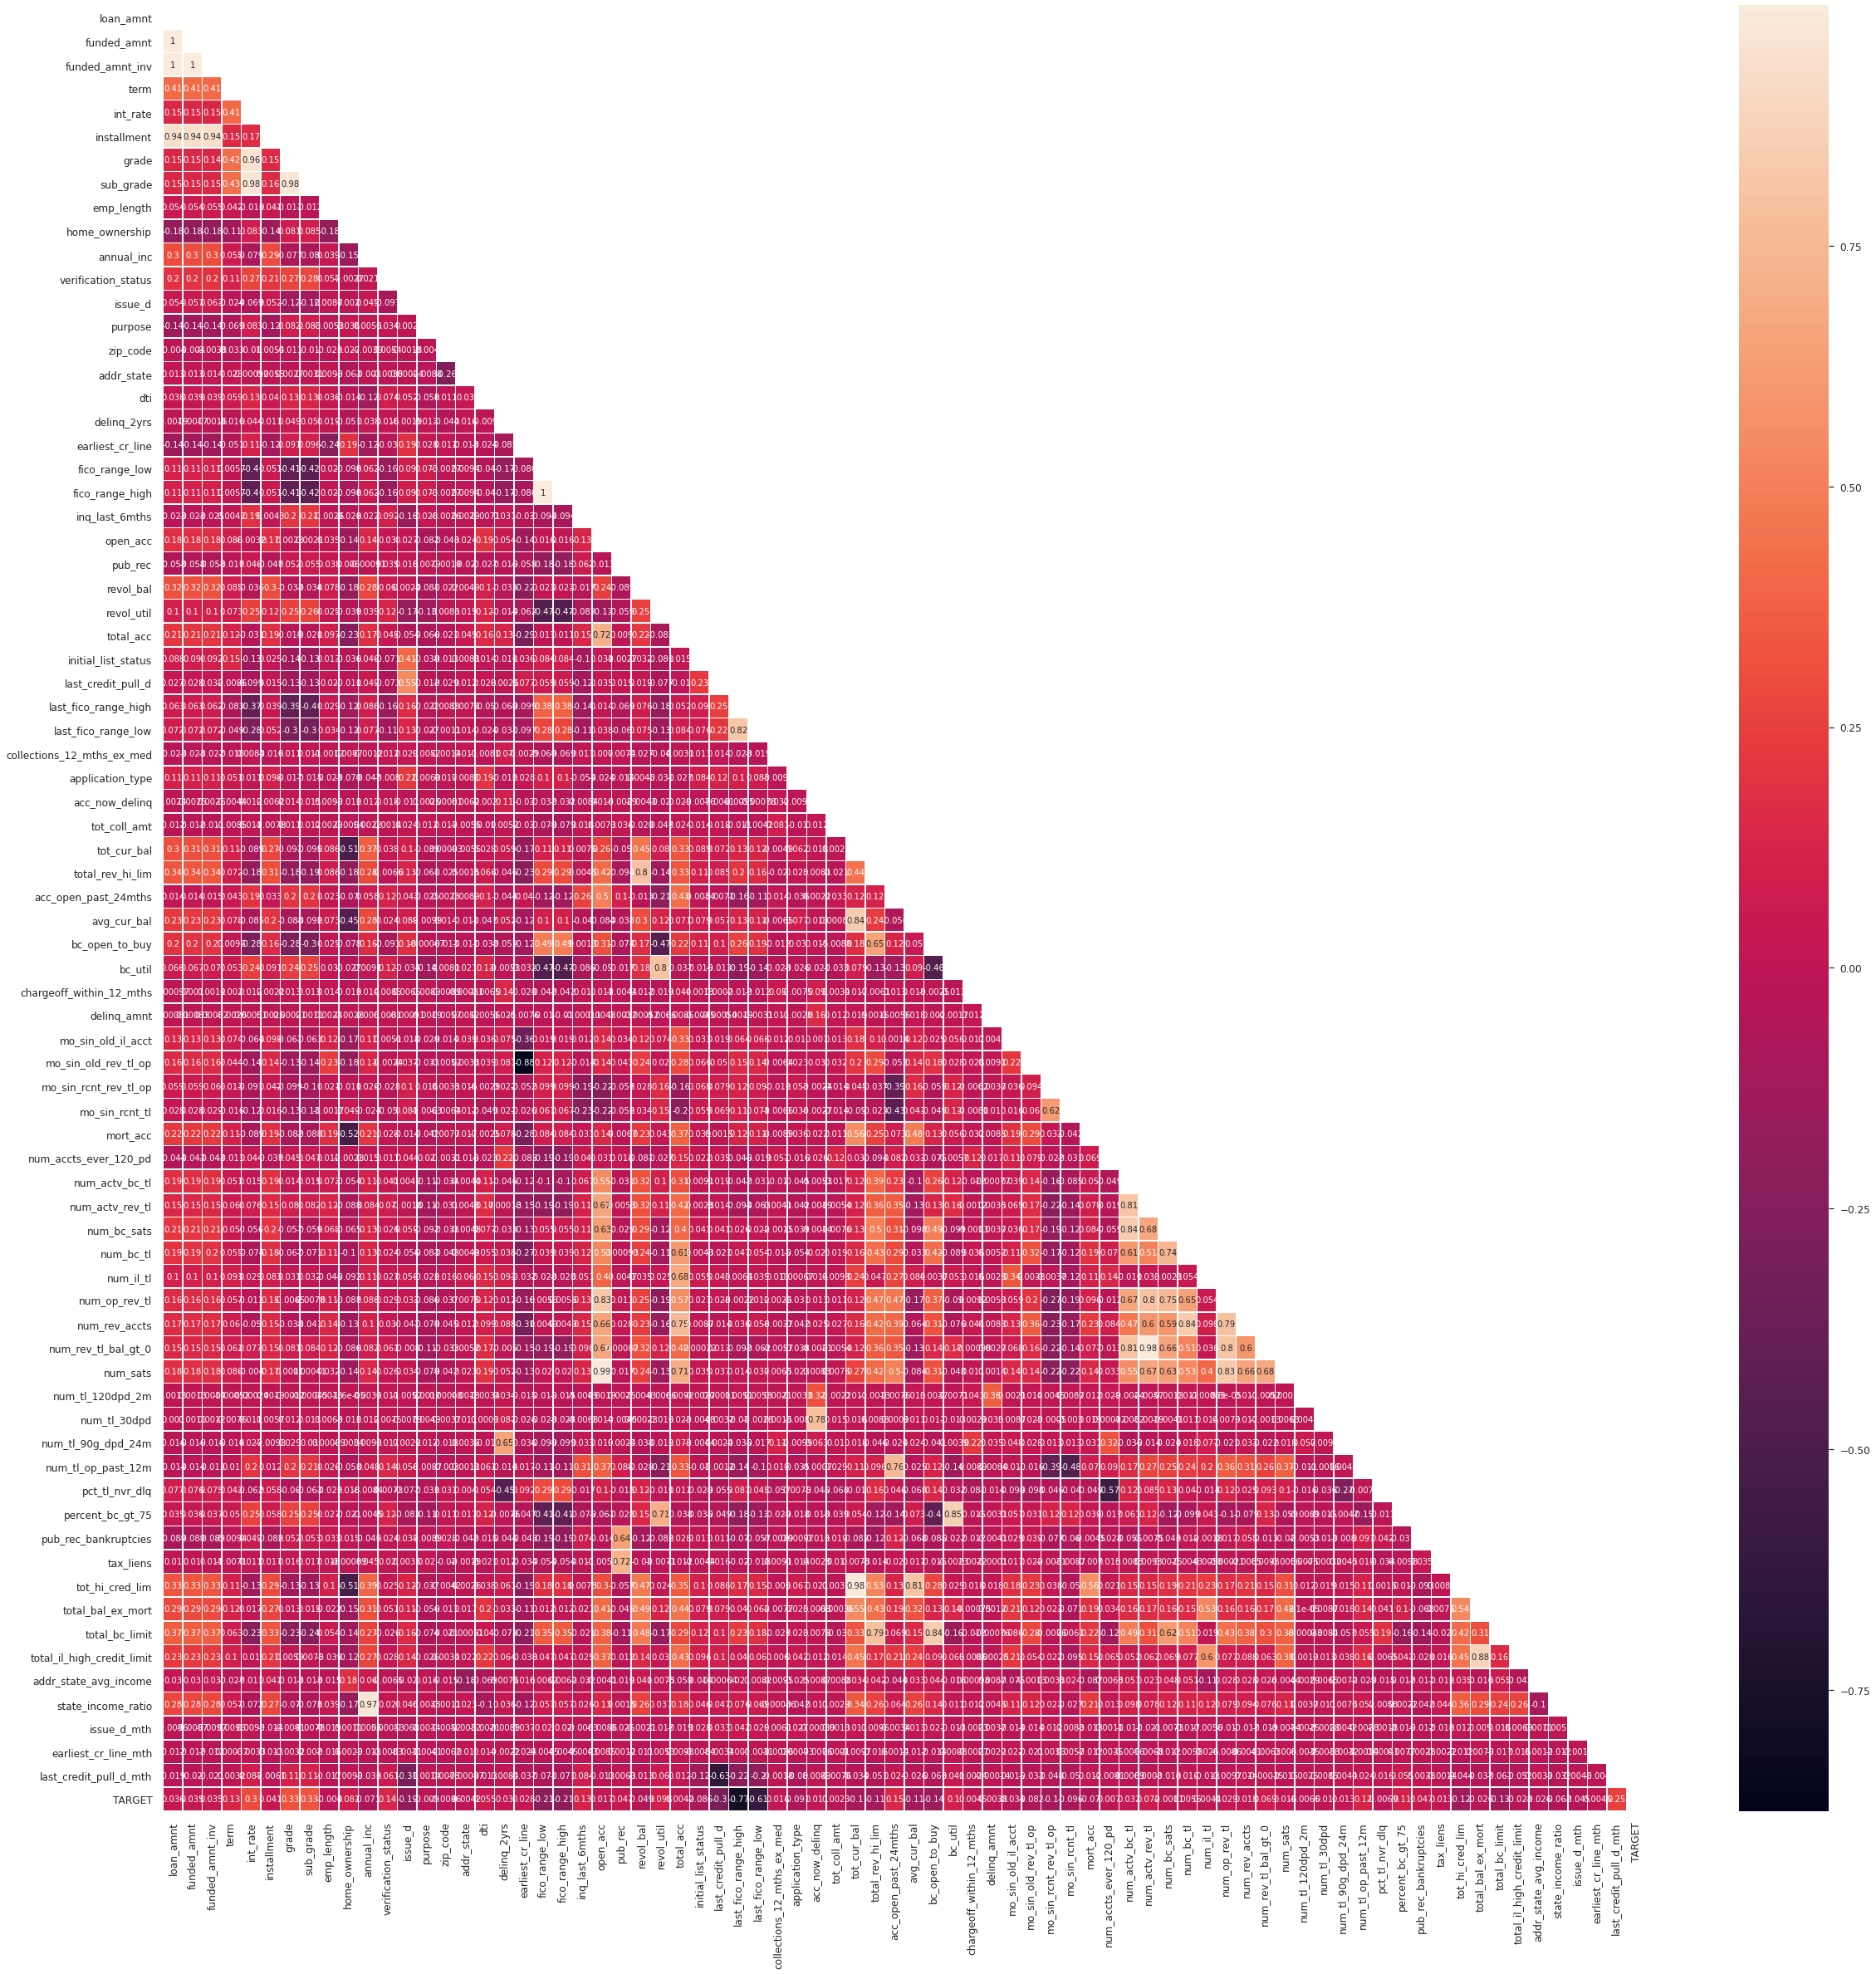

In [74]:
fig, ax = plt.subplots(figsize=(40,40))       

corr = data_preprocessed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr, annot=True, linewidths=.5, ax=ax, mask=mask)
plt.show()

As it can be seen in the above there are several features with high correlation. Let's further investigate these.

In [75]:
# calculate abs correlation to take strong positive and negative correlations into account.
corr_abs = corr.abs()

pairs = corr.unstack()
pairs_ordered = pairs.sort_values(kind="quicksort", ascending=False)

print(pairs_ordered[pairs_ordered < 1.0].head(30))

fico_range_high             fico_range_low                1.000000
fico_range_low              fico_range_high               1.000000
loan_amnt                   funded_amnt                   0.999703
funded_amnt                 loan_amnt                     0.999703
                            funded_amnt_inv               0.999293
funded_amnt_inv             funded_amnt                   0.999293
loan_amnt                   funded_amnt_inv               0.998936
funded_amnt_inv             loan_amnt                     0.998936
open_acc                    num_sats                      0.990119
num_sats                    open_acc                      0.990119
tot_cur_bal                 tot_hi_cred_lim               0.984076
tot_hi_cred_lim             tot_cur_bal                   0.984076
num_rev_tl_bal_gt_0         num_actv_rev_tl               0.983505
num_actv_rev_tl             num_rev_tl_bal_gt_0           0.983505
sub_grade                   grade                         0.97

We decided to drop columns with a high correlation and keep only one of them. This is similar to the paper *Credit Risk Analysis in Peer-to-Peer Lending System*.

In [76]:
data_preprocessed = data_preprocessed.drop(columns=['fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'num_sats'])

## Task 3: Use LASSO for variable selection and explain results. (15 points)

In Task 3 we use a LASSO model for variable selection. First we run a grid search to find a suitable value for the penalty weight $\alpha$. We use the metric Area under the curve (AUC) is the criteria for model selection.

In [77]:
# Ressources M / V

# Find optimal alpha: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV
# use LassoCV to find the optimal alpha:

lasso = LassoCV(cv=5, random_state=0, max_iter=5000).fit(X, y)
model = SelectFromModel(lasso, prefit=True)
X_new = model.transform(X)
print('X shape: ', X_new.shape)
print('lasso_coef: ', lasso.coef_)
print('lasso_intercept: ', lasso.intercept_)
print('lasso_alpha: ', lasso.alpha_)
lasso_alpha = lasso.alpha_
# + Gridsearch for LASSO

# https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py
# Alternative: https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X shape:  (171494, 45)
lasso_coef:  [-0.00000000e+00 -9.38397534e-02 -0.00000000e+00  6.33456289e-02
 -2.86912648e-01  2.97762091e-01  6.78267522e-02  2.53333075e-01
  1.30474936e-02  9.16939613e-03 -1.90590538e-01  5.08830002e-03
 -2.35428701e-02 -7.20198172e-02 -7.36597245e-03 -5.51711723e-03
  2.81306077e-01 -0.00000000e+00 -1.34806850e-02  2.94414259e-01
  0.00000000e+00  4.38427832e-03  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -8.83456772e-02  4.13936056e-02 -3.51771280e-03
 -5.25369712e-01 -4.16612772e+00  2.51076845e-01  0.00000000e+00
 -2.18964090e-02  0.00000000e+00  0.00000000e+00 -1.52753396e-01
 -0.00000000e+00  8.30441511e-02 -0.00000000e+00  2.24650442e-01
  6.74813090e-02 -0.00000000e+00 -0.00000000e+00  2.34902677e-02
  8.51694680e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.20986906e-03 -0.00000000e+00 -1.21264630e-01
  1.98631583e-02  0.00000000e+00 -0.00000000e+00  1.21021697e-01
 -9.67198475e-02  0.00000000e+00 -0.00000000e+00  0.00

In [78]:
X.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,addr_state_avg_income,state_income_ratio,issue_d_mth,earliest_cr_line_mth,last_credit_pull_d_mth
0,0.744898,0.744898,0.75000,1.0,0.198988,0.390248,0.166667,0.205882,0.3,1.0,0.009661,0.5,1.000000,0.153846,0.108193,0.68,0.009219,0.0,0.956522,0.465116,0.462963,0.0,0.171429,0.0,0.004840,0.110198,0.106870,1.0,1.0,0.875294,0.875740,0.0,0.0,0.0,0.0,0.002096,0.023494,0.066667,0.001977,0.068706,0.127936,0.0,0.0,0.037097,0.073710,0.060694,0.039526,0.0,0.0,0.162162,0.166667,0.142857,0.102941,0.023256,0.164179,0.125000,0.210526,0.171429,0.0,0.0,0.0,0.04,1.0,0.000,0.0,0.0,0.006784,0.010089,0.081999,0.012813,0.728465,0.006998,0.000000,0.727273,0.181818
1,0.580357,0.580357,0.58875,0.0,0.079439,0.444872,0.000000,0.088235,1.0,0.2,0.008086,0.0,0.909091,0.153846,0.942227,0.08,0.003664,0.0,0.710145,0.627907,0.625000,0.0,0.085714,0.0,0.003990,0.249144,0.106870,1.0,1.0,0.845882,0.846154,0.0,0.0,0.0,0.0,0.064633,0.008552,0.044444,0.121952,0.004136,0.476514,0.0,0.0,0.248387,0.312039,0.052023,0.071146,0.1,0.0,0.081081,0.083333,0.071429,0.102941,0.046512,0.074627,0.086538,0.105263,0.085714,0.0,0.0,0.0,0.00,1.0,0.667,0.0,0.0,0.065659,0.003827,0.017092,0.000000,0.859463,0.005477,0.454545,1.000000,0.181818
2,0.336735,0.336735,0.35000,0.0,0.358645,0.289151,0.333333,0.352941,0.0,1.0,0.004200,0.0,1.000000,0.153846,0.178571,0.76,0.007207,0.0,0.942029,0.348837,0.347222,0.0,0.085714,0.0,0.003151,0.279945,0.053435,0.0,1.0,0.834118,0.834320,0.0,1.0,0.0,0.0,0.001006,0.006023,0.000000,0.001898,0.000336,0.601360,0.0,0.0,0.109677,0.093366,0.092486,0.126482,0.0,0.0,0.054054,0.041667,0.047619,0.029412,0.046512,0.044776,0.038462,0.052632,0.085714,0.0,0.0,0.0,0.00,1.0,1.000,0.0,0.0,0.002003,0.004840,0.011900,0.005825,0.415045,0.003648,0.454545,0.818182,0.181818
3,0.285714,0.285714,0.30000,0.0,0.446651,0.254415,0.333333,0.411765,0.1,0.2,0.005250,1.0,0.545455,0.076923,0.872899,0.64,0.020661,0.0,0.724638,0.372093,0.370370,0.0,0.057143,0.0,0.005169,0.556468,0.038168,0.0,1.0,0.857647,0.857988,0.0,0.0,0.0,0.0,0.003714,0.004966,0.022222,0.010511,0.004616,0.502472,0.0,0.0,0.343548,0.229730,0.101156,0.035573,0.0,0.0,0.054054,0.041667,0.047619,0.044118,0.046512,0.029851,0.019231,0.052632,0.057143,0.0,0.0,0.0,0.04,1.0,1.000,0.0,0.0,0.003703,0.017874,0.023367,0.024518,0.094927,0.005722,0.636364,0.000000,0.181818
4,0.145408,0.145408,0.16250,0.0,0.376947,0.128525,0.333333,0.382353,0.2,1.0,0.005776,1.0,0.909091,0.692308,0.053571,0.12,0.020180,0.0,0.942029,0.209302,0.208333,0.0,0.100000,0.0,0.003950,0.399042,0.038168,1.0,1.0,0.787059,0.786982,0.0,0.0,0.0,0.0,0.008654,0.005287,0.066667,0.013996,0.004648,0.461063,0.0,0.0,0.101613,0.033170,0.005780,0.007905,0.0,0.0,0.054054,0.083333,0.047619,0.029412,0.034884,0.059701,0.028846,0.105263,0.100000,0.0,0.0,0.0,0.04,1.0,0.500,0.0,0.0,0.008889,0.041648,0.017309,0.073637,0.933203,0.003775,0.181818,0.818182,0.181818


In [79]:
# https://scikit-learn.org/stable/modules/feature_selection.html#l1-feature-selection
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html

lasso = Lasso(alpha=lasso_alpha).fit(X, y)
model = SelectFromModel(lasso, prefit=True, max_features=25)
feature_idx = model.get_support()
feature_name = X.columns[feature_idx]
X_new = pd.DataFrame(model.transform(X), columns=feature_name)
print(X_new.shape)
X_new.head

(171494, 25)


<bound method NDFrame.head of         funded_amnt  term  ...  tot_hi_cred_lim  total_il_high_credit_limit
0          0.744898   1.0  ...         0.006784                    0.012813
1          0.580357   0.0  ...         0.065659                    0.000000
2          0.336735   0.0  ...         0.002003                    0.005825
3          0.285714   0.0  ...         0.003703                    0.024518
4          0.145408   0.0  ...         0.008889                    0.073637
...             ...   ...  ...              ...                         ...
171489     0.693878   1.0  ...         0.006949                    0.044740
171490     0.143495   0.0  ...         0.006047                    0.053707
171491     0.416454   0.0  ...         0.018066                    0.091520
171492     0.234694   0.0  ...         0.002995                    0.020887
171493     0.311224   1.0  ...         0.043316                    0.060338

[171494 rows x 25 columns]>

In [80]:
# nur die features in den Modellen verwenden?
# X = X_new

Next we look at variables, that....

To compare the models in the end a DataFrame with all performance metrics is created.

In [81]:
results = pd.DataFrame()

## Task 4: Use logistic regression (in-sample) for default prediction. Interpret your results for logistic regression. (20 points)

For in-sample testing a concatenation of test and training dataset is required.

In [82]:
def print_results_in_sample(model, results):

    y_pred_model = model.predict(X)

    print(classification_report(y, y_pred_model))
    
    # TODO: Concat train and test and use entire dataset V --> done
    plot_confusion_matrix(model, X, y, display_labels=['Non-Default', 'Default'])
    plt.show()

    # TODO: balanced accuracy, matthews corr coeff V
    print(f"Accuracy: {accuracy_score(y, y_pred_model):.2f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y, y_pred_model):.2f}")
    print(f"Matthews Corrcoef: {matthews_corrcoef(y, y_pred_model):.2f}")
    print(f"Params: {model.get_params()}")

    performance = pd.DataFrame({'Accuracy':accuracy_score(y, y_pred_model), 'Balanced Accuracy':balanced_accuracy_score(y, y_pred_model), 'Matthews Corrcoef': matthews_corrcoef(y, y_pred_model)}, index=['Logistic Regression'])
    results = results.append(performance)
    return results


In [83]:
# based on https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html
def print_performance_measures_in_sample(model):

    # Instantiate the visualizer with the classification model
    roc_auc(model, X, y, classes=["Default", "Non-Default"], binary=True)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

              precision    recall  f1-score   support

       False       0.92      0.92      0.92     98274
        True       0.89      0.89      0.89     73220

    accuracy                           0.91    171494
   macro avg       0.91      0.90      0.90    171494
weighted avg       0.91      0.91      0.91    171494



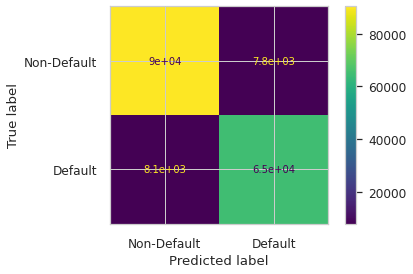

Accuracy: 0.91
Balanced Accuracy: 0.90
Matthews Corrcoef: 0.81
Params: {'C': 2.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 250, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


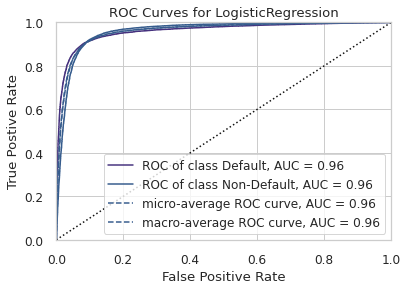

In [84]:
#distributions = dict(penalty=['l1', 'l2', 'elasticnet'], tol=expon(scale=.01), C=uniform(loc=0.1, scale=0.1), solver= ['saga'], max_iter=uniform(loc=100, scale=100), l1_ratio=uniform(loc=0, scale=0.1))
#rand_lg = RandomizedSearchCV(LogisticRegression(), distributions, random_state=42, n_iter=20)
#search = rand_lg.fit(X_train, y_train)
#print(search.best_params_)

# TODO: perform grid search V
# Either set error score in paramgrid to 0 https://stackoverflow.com/a/43010440
# or use liblinear (universal solver instead) https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
# Vary penalty, reduce no. of combinations
##param_grid = {'penalty': ['l1', 'l2'], 'tol': [1e-6, 1e-4, 1e-2], 'solver': ['liblinear'], 'max_iter': [100, 200, 500]}
##param_grid = {'tol': [1e-5, 1e-4, 1e-3], 'C': [0.1, 0.2], 'solver': ['newton-cg', 'lbfgs', 'sag'], 'max_iter': [100, 200, 500]}

param_grid = {'penalty': ['l1', 'l2', 'elasticnet'], 'tol': [1e-4, 1e-3], 'C': [0.5, 1.0, 2.0], 'solver': ['saga'], 'max_iter': [250, 500]}
grid_lg = GridSearchCV(LogisticRegression(), param_grid,  error_score=0.0)

# TODO: Concat train and test and use entire dataset
grid_lg.fit(X, y.values.ravel())

# choose best model
grid_lg_optimized = grid_lg.best_estimator_

# print confusion 
results = print_results_in_sample(grid_lg_optimized, results)
results

print_performance_measures_in_sample(grid_lg_optimized)

In [85]:
results

,Accuracy,Balanced Accuracy,Matthews Corrcoef
Logistic Regression,0.906901,0.904593,0.809641


##QUESTION: Da wir in-sampling haben macht eine extrem hohe Accuracy eigentlich Sinn oder?

## Task 5: Compare logistic regression, classification tree, random forest, bagging, support vector machine (with two kernel functions), and neural network for default prediction based on the out-of-sample performance measures (at least three different measures). (35 points)

### Preliminary

In [86]:
def print_results(model):

    y_pred_model = model.predict(X_test)


    print(classification_report(y_test, y_pred_model))

    fig, ax = plt.subplots(figsize=(16, 9))
    disp = plot_confusion_matrix(model, X_test, y_test, display_labels=['Non-Default', 'Default'], ax=ax)
    plt.title(f"Confusion matrix for {model.__class__.__name__}")
    disp.ax_.grid(False)
    plt.show()

    
    #print(f"Accuracy: {accuracy_score(y_test, y_pred_model):.2f}")
    #print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_model):.2f}")
    #print(f"MCC: {matthews_corrcoef(y_test, y_pred_model):.2f}")
    #print()
    #print(f"Params: {model.get_params()}")

    performance_metrics = pd.DataFrame({'Accuracy':accuracy_score(y_test, y_pred_model), 'Balanced Accuracy':balanced_accuracy_score(y_test, y_pred_model), 'Matthews Corrcoef': matthews_corrcoef(y_test, y_pred_model)}, index=[f"{model.__class__.__name__}"])
 
    return performance_metrics

In [87]:
# based on https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html
def print_performance_measures(model):

    # Instantiate the visualizer with the classification model
    plt.figure(figsize=(9, 9))
    # FIXME: binary flag not working. Figure out why.
    roc_auc(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=["Default", "Non-Default"], binary=True)
    plt.show()

### Decision Tree

              precision    recall  f1-score   support

       False       0.97      0.94      0.96     29482
        True       0.68      0.79      0.73      4428

    accuracy                           0.92     33910
   macro avg       0.82      0.86      0.84     33910
weighted avg       0.93      0.92      0.93     33910



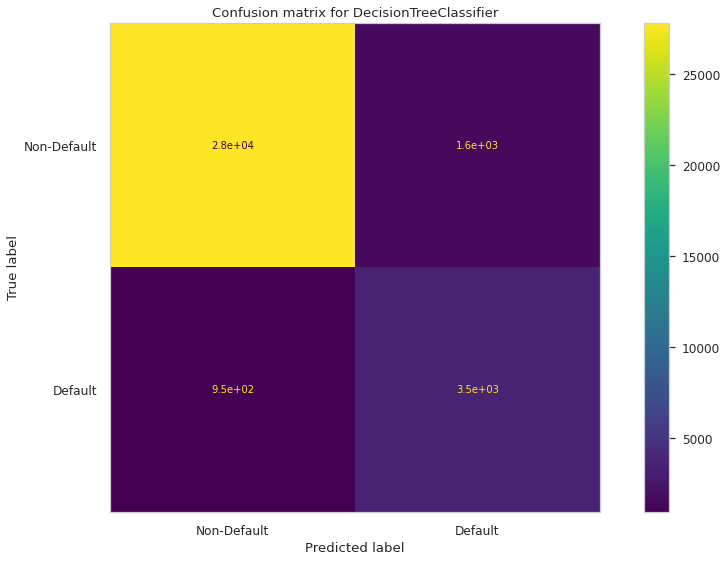

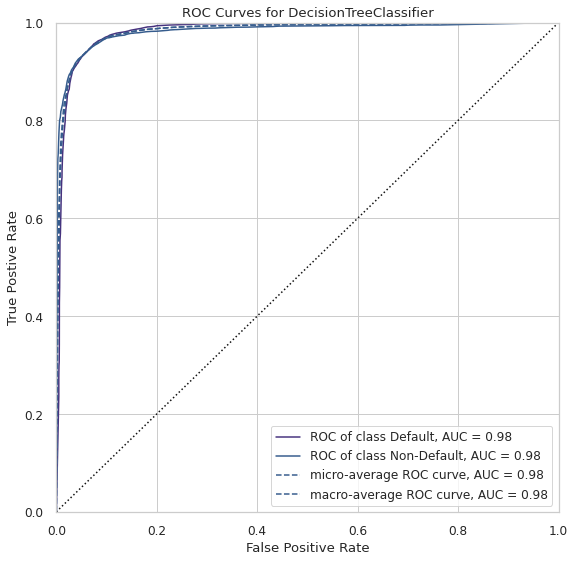

In [88]:
# TODO: perform randomized search first. Use as boilerplate for other models laster V / M
# TODO: When is which distribution suitable?
#distributions = dict(criterion=['gini', 'entropy'], max_depth=uniform(loc=2, scale=4), min_samples_leaf=[0.5, 1], min_weight_fraction_leaf=expon(scale=.1))
#rand_dt = RandomizedSearchCV(DecisionTreeClassifier(), distributions, random_state=42, n_iter=20)
#search = rand_dt.fit(X_train, y_train)
#print(search.best_params_)

# max_depth = [2, 6, 10, 14...]
min_depth = 2
step_size = 4
step_count = 2**4
max_depth = min_depth + np.arange(step_count) * step_size


# perform grid search
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': max_depth}
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid, refit=True, verbose=0)
grid_dt.fit(X_train, y_train)

# choose best model
grid_dt_optimized = grid_dt.best_estimator_

# print confusion 
performance_metrics = print_results(grid_dt_optimized)

print_performance_measures(grid_dt_optimized)

In [89]:
performance_metrics

,Accuracy,Balanced Accuracy,Matthews Corrcoef
DecisionTreeClassifier,0.923798,0.86492,0.687391


### Plot Decision Tree

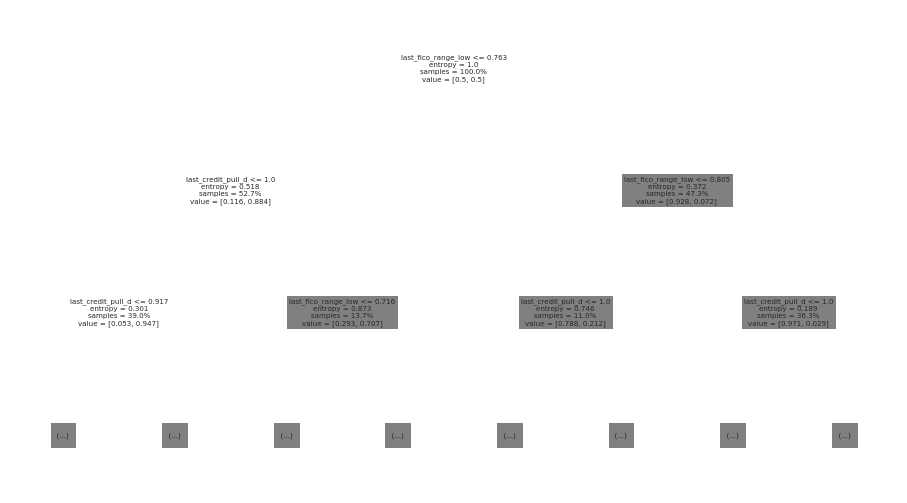

In [90]:
fig, ax = plt.subplots(figsize=(16, 9))
tree.plot_tree(grid_dt_optimized, feature_names=X_train.columns, proportion=True, max_depth=2);

### Plot feature importances of Decision Tree

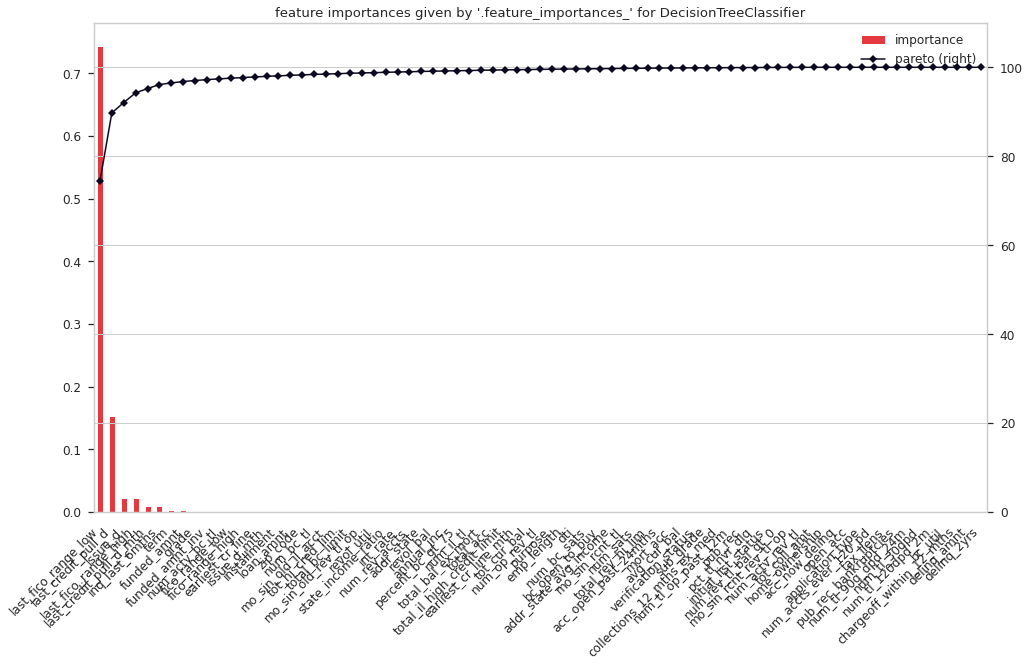

In [91]:
def print_feature_importance(feature_importance):
    """
    function to create a paretto plot with the gini importance of features.
    """
    feature_importance.sort_values(ascending=False, inplace=True, by=0)

    feature_importance['pareto'] = 100 *feature_importance[0].cumsum() / feature_importance[0].sum()
    feature_importance.rename(columns={0:'importance'}, inplace=True)

    fig, axes = plt.subplots(figsize=(16,9))
    ax1 = feature_importance.plot(use_index=True, y='importance',  kind='bar', ax=axes, color=cmap(150))
    ax2 = feature_importance.plot(use_index=True, y='pareto', marker='D', color=cmap(7), kind='line', ax=axes, secondary_y=True)
    ax2.set_ylim([0,110])
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.xticks(rotation=45)
    plt.title(f"feature importances given by '.feature_importances_' for {grid_dt_optimized.__class__.__name__}")
    plt.show()


 
importance = grid_dt_optimized.feature_importances_
feature_importance = pd.DataFrame(importance, X_train.columns)

print_feature_importance(feature_importance)

### Random Forest

In [ ]:
# [2, 6, 10, 14...]
max_depth = np.arange(2, 22, 4)
# [5, 10, 25, 50, 100, 150]
n_estimators = [5, 10, 25, 50, 100, 150]

# perform grid search
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': max_depth, 'n_estimators': n_estimators, 'max_features': ['auto', 'sqrt', 'log2']}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=0)
grid_rf.fit(X_train, y_train.values.ravel())

# choose best model
grid_rf_optimized = grid_rf.best_estimator_

# print confusion 
performance_metrics = print_results(grid_rf_optimized)

print_performance_measures(grid_rf_optimized)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

In [1]:
performance_metrics

NameError: ignored

### Bagging

In [ ]:
# TODO: Validate results with larger dataset

# perform grid search
param_grid = {'n_estimators': [5, 10, 25, 50, 100, 150], 'max_samples': [1, 2, 3, 4, 5], 'max_features': [1, 2, 3]}
grid_bag = GridSearchCV(BaggingClassifier(), param_grid, refit=True, verbose=0)
grid_bag.fit(X_train, y_train)

# choose best model
grid_bag_optimized = grid_bag.best_estimator_

# print confusion 
performance_metrics = print_results(grid_bag_optimized)
print_performance_measures(grid_bag_optimized)

In [ ]:
performance_metrics

### Support Vector Machine

Next, we look at SVM with two different kernels. Namely, a rfb kernel and linear kernel.

In [ ]:
min_c = 0.1
step_size = 0.1
step_count = 15

C = min_c + np.arange(step_count) * step_size

param_grid = {'C': C, 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear']}
grid_svm = GridSearchCV(SVC(), param_grid, refit=True, verbose=0)
grid_svm.fit(X_train, y_train.values.ravel())

# choose best model
grid_svm_optimized = grid_svm.best_estimator_

# print confusion 
performance_metrics = print_results(grid_svm_optimized)

print_performance_measures(grid_svm_optimized)

In [ ]:
performance_metrics

### Neural Network 

In [ ]:
param_grid = {'activation': ['logistic', 'relu'], 'learning_rate': ['constant', 'invscaling'], 'hidden_layer_sizes': [(100, 1), (100, 2)], 'early_stopping': True}
grid_nn = GridSearchCV(MLPClassifier(), param_grid, refit=True, verbose=0)
grid_nn.fit(X_train, y_train.values.ravel())

# choose best model
grid_nn_optimized = grid_nn.best_estimator_

# print confusion 
performance_metrics = print_results(grid_nn_optimized)

print_performance_measures(grid_nn_optimized)

In [ ]:
performance_metrics

### Voting Classifier

In [ ]:
# TODO: Optional. Combine the best Classifiers e. g. SVM and RF
model_voting = VotingClassifier(estimators=[('SVM', grid_svm_optimized), ('Random Forest', model_rf_optimized)],
                                   voting='hard')
model_voting.fit(X_train, y_train.values.ravel())

# print confusion matrix
print_result(model_voting)

Bringing it all together....

## Task 6: Which model do you suggest to the peer-to-peer company? Why? (10 points)

In addition to accuracy-based measures, classifiers can be compared from following aspects:
*   Speed
*   Interpretability (e.g. logistics regression and decision trees are interpretable, rest not really)
*   Robustness: This refers to the ability of the classifiers to classifying noisy data or data with missing values.
*   Scalability: This is the ability of the classifier to work with large amount of data.

In [ ]:
# TODO: Not yet implemented...
# Discussion Voting Classifier -> include short discussion of weaknesses and strengths of models and weaknesses
# Plot Treefunction DT Path tree.plot_tree(clf) 

# Crieria from slide


# Disucssion why accuarcy is a good criteria (balanced data)

# TODO: consider cost function. Loans that can not repaid are more expensive than loans, that are not handed out.